# WCWH Rollout Preparation
Working to get the beacons ready for their next adventure. 

In [9]:
import warnings
warnings.filterwarnings('ignore')

# Setup
Here we define some important variables and set up the notebook.

In [10]:
import os
import sys
sys.path.append('../')

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from src.visualization import visualize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constant Variables

In [11]:
beacons = [1,2,4,5,7,8,9,10,12,13,14,15,16,17,18,19,21,22,23]
raw_data_dir = "/Users/hagenfritz/Projects/utx000/data/raw/wcwh_pilot/beacon/"

## Functions

In [16]:
def import_beacon_data(beacon_list, start_time=datetime(2021,4,15), end_time=datetime(2022,1,1), resample_rate=5, data_dir="/Users/hagenfritz/Projects/utx000/data/raw/wcwh_pilot/beacon/"):
    """imports beacon data"""
    data = pd.DataFrame()
    for beacon in beacon_list:
        number = f'{beacon:02}'
        data_by_beacon = pd.DataFrame()
        #print(beacon)
        try:
            for file in os.listdir(f"{raw_data_dir}B{number}/DATA/"):
                if file[-1] == "v":
                    #print(file)
                    temp = pd.read_csv(f"{raw_data_dir}B{number}/DATA/{file}")
                    if len(temp) > 0:
                        data_by_beacon = data_by_beacon.append(temp)
            if len(data_by_beacon) > 0:
                data_by_beacon["Timestamp"] = pd.to_datetime(data_by_beacon["Timestamp"])
                data_by_beacon.dropna(subset=["Timestamp"],inplace=True)
                data_by_beacon.set_index("Timestamp",inplace=True)
                data_by_beacon.sort_index(inplace=True)
                data_by_beacon = data_by_beacon.sort_index()[start_time:end_time]
                data_by_beacon = data_by_beacon.resample(f"{resample_rate}T").mean()
                data_by_beacon["beacon"] = int(number)
                data = data.append(data_by_beacon)
        except FileNotFoundError:
            print(f"No files found for beacon {beacon}.")
            
    data['temperature_c'] = data[['T_CO','T_NO2']].mean(axis=1)
    data['rh'] = data[['RH_CO','RH_NO2']].mean(axis=1)
    data.drop(["eCO2","Visible","Infrared","Temperature [C]","Relative Humidity","PM_N_0p5","T_CO","T_NO2","RH_CO","RH_NO2"],axis="columns",inplace=True)
    data = data[[column for column in data.columns if "1" not in column and "4" not in column]]
    data.reset_index(inplace=True)
    data.columns = ["timestamp","tvoc","lux","co","no2","pm2p5_number","pm2p5_mass","co2","beacon","temperature_c","rh"]
    data["co"] /= 1000
    return data

# Beacon Inspection
Prior to calibrating, I want to make sure the beacons are working well.

## Importing Beacon Data

In [17]:
raw_data = import_beacon_data(beacons)
raw_data.head()

timestamp  tvoc       lux       co      no2  pm2p5_number  \
0 2021-04-16 11:15:00   8.0  36.65880 -1.71075  100.875     23.251494   
1 2021-04-16 11:20:00   8.0  33.88032 -1.69520  102.600     22.007837   
2 2021-04-16 11:25:00  11.4  35.13696 -1.61340  100.600     16.007511   
3 2021-04-16 11:30:00   9.0  43.94976 -1.59060  105.200     22.390266   
4 2021-04-16 11:35:00  10.8  34.05984 -1.56480  104.200     13.268704   

   pm2p5_mass         co2  beacon  temperature_c    rh  
0    5.144908  201.057677       1           24.5  42.0  
1    5.136604  218.258014       1           24.5  42.0  
2    2.340240  197.375302       1           24.5  42.0  
3    4.884278  176.849715       1           24.5  42.0  
4    2.653524  190.081656       1           24.5  42.0

## Examining Data Availabaility
Number of data points per beacon (including `NaN` measurement from some sensors).

In [18]:
for beacon in raw_data["beacon"].unique():
    data_by_beacon = raw_data[raw_data["beacon"] == beacon]
    #data_by_beacon.dropna(inplace=True)
    print(f"Beacon {beacon}:\t{len(data_by_beacon)}")

Beacon 1:	7802
Beacon 2:	7774
Beacon 4:	7770
Beacon 5:	7775
Beacon 7:	7775
Beacon 8:	5743
Beacon 9:	8225
Beacon 10:	7720
Beacon 12:	7704
Beacon 13:	7701
Beacon 15:	7528
Beacon 16:	7518
Beacon 17:	5532
Beacon 18:	5531
Beacon 19:	7678
Beacon 21:	7518
Beacon 23:	5520


## Visualizing

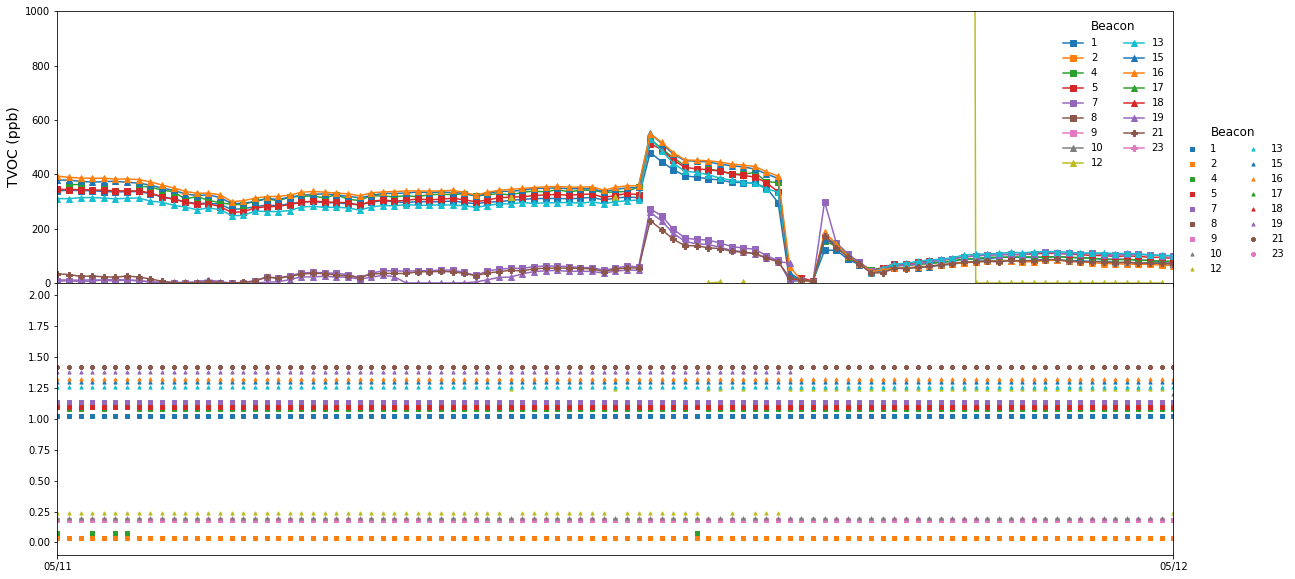

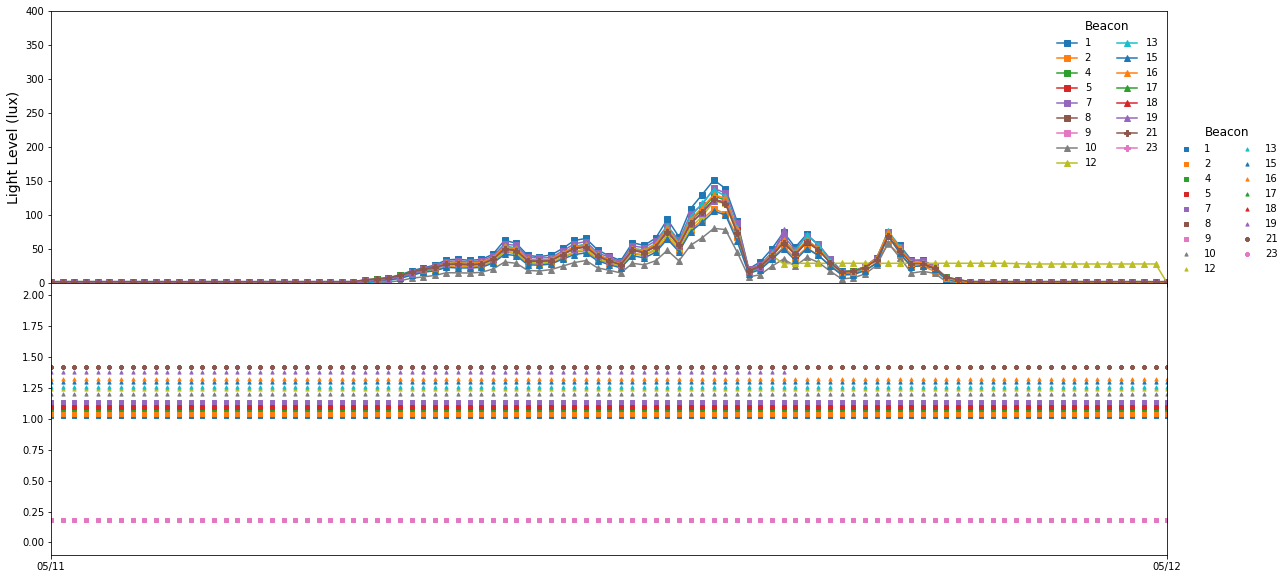

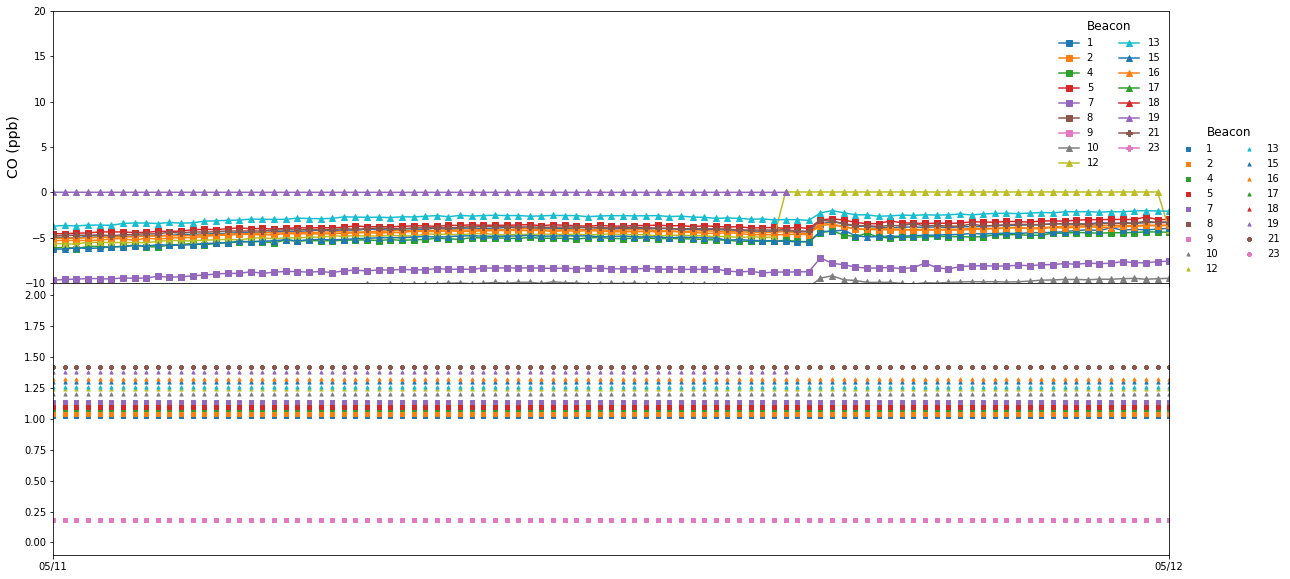

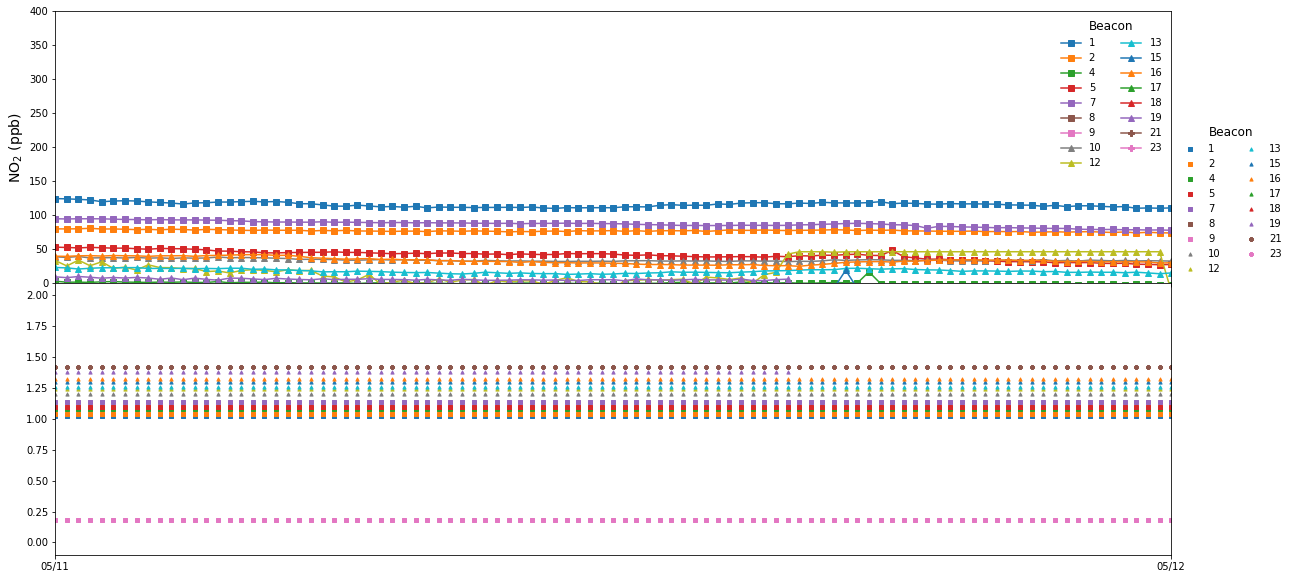

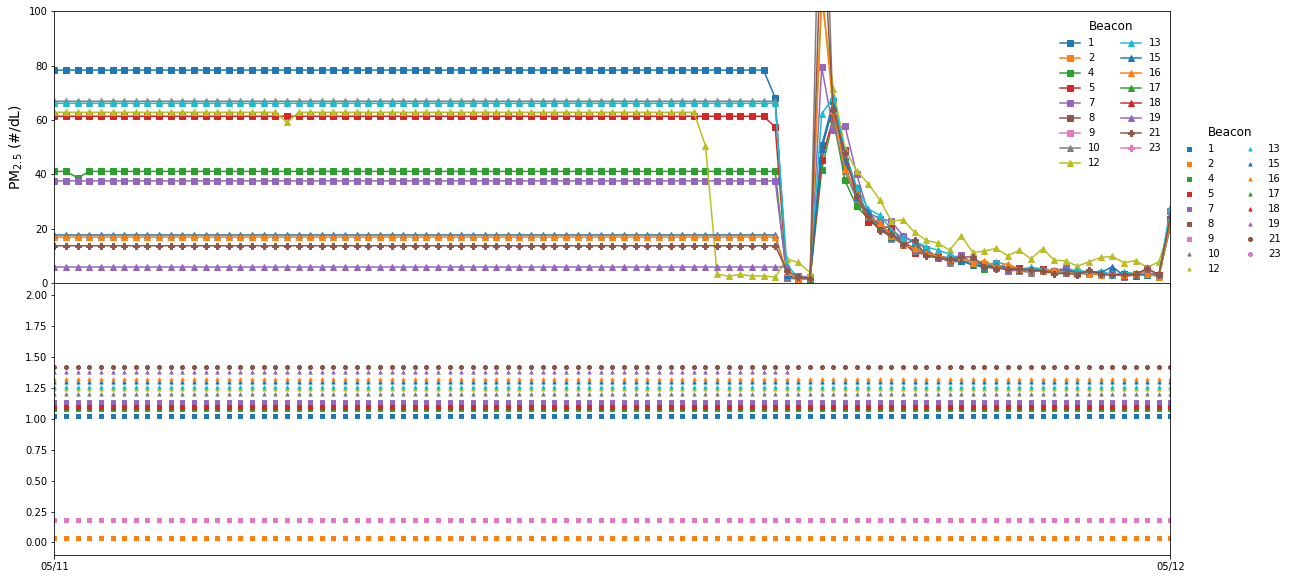

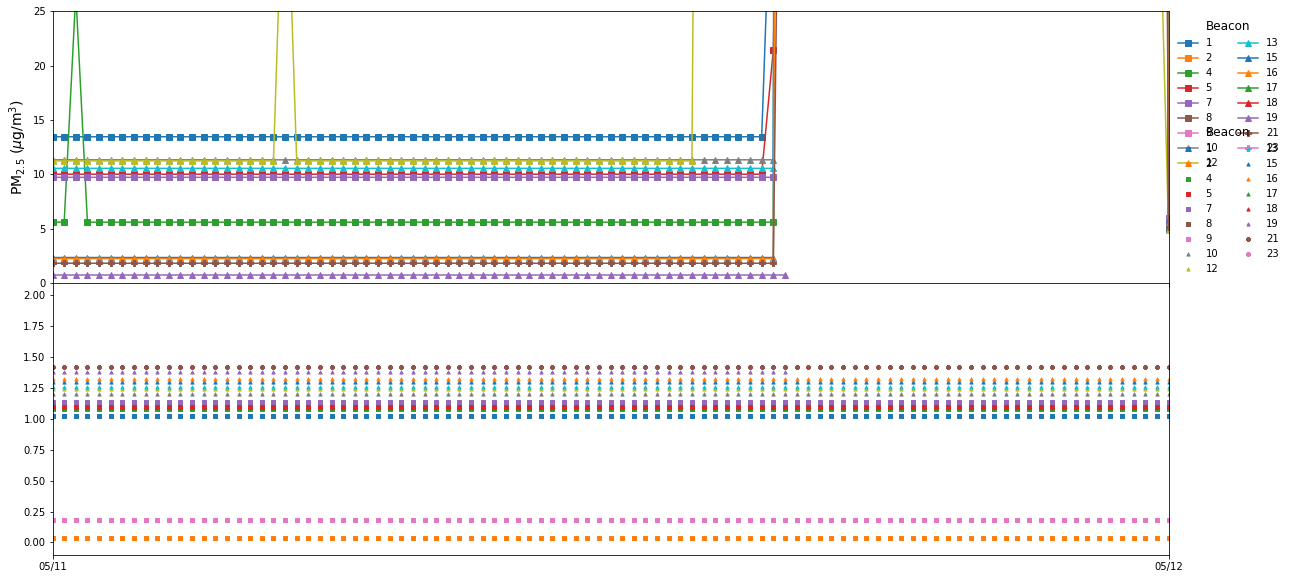

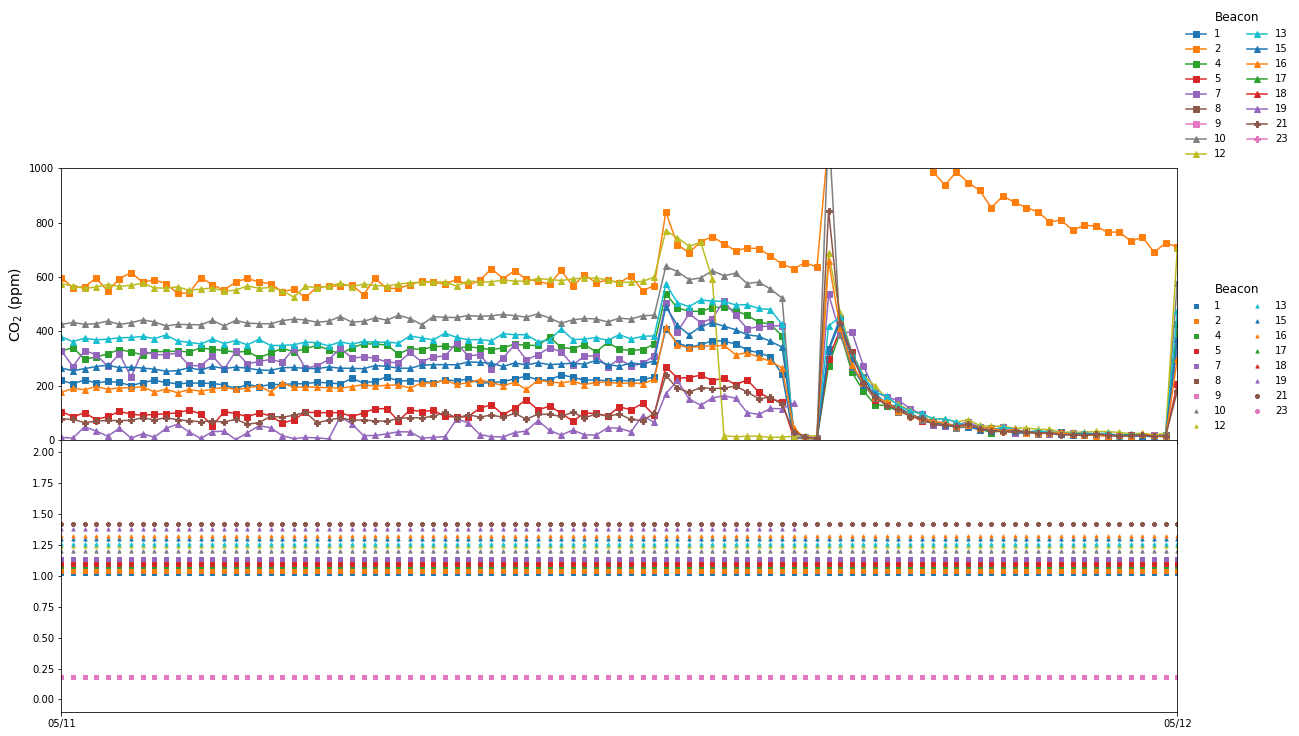

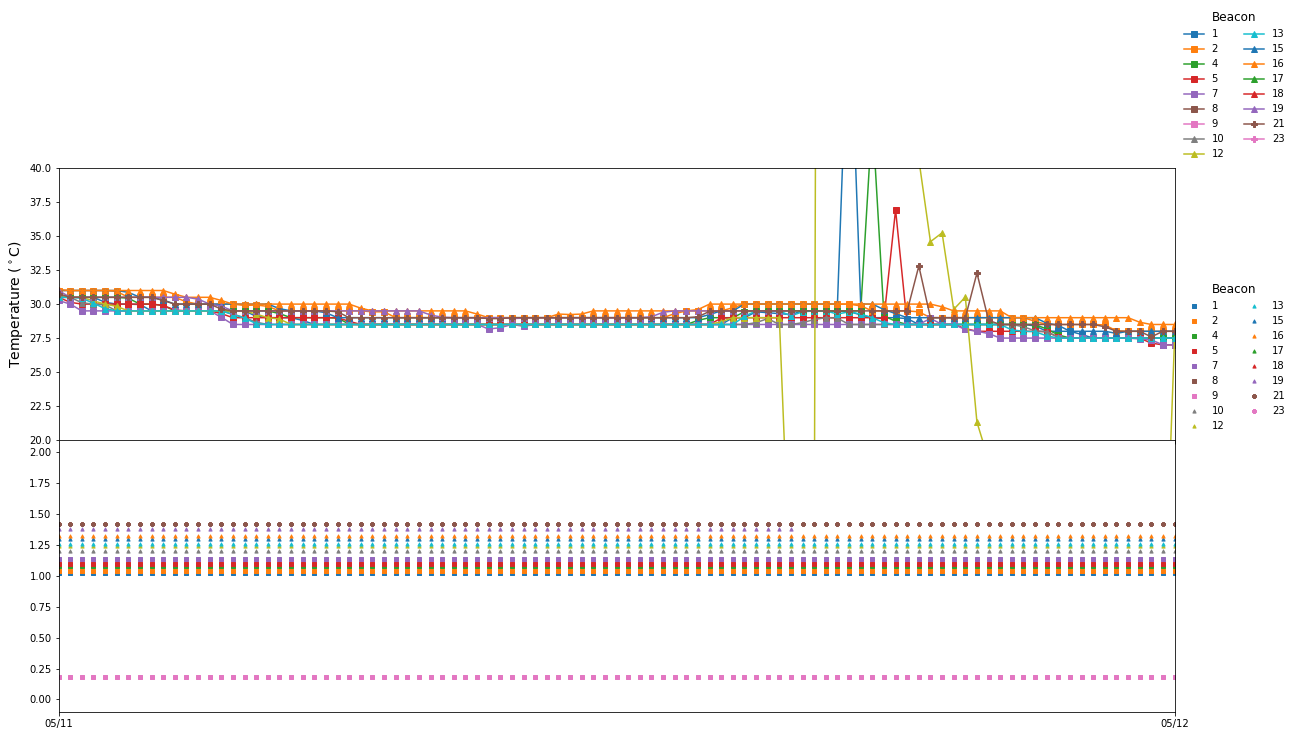

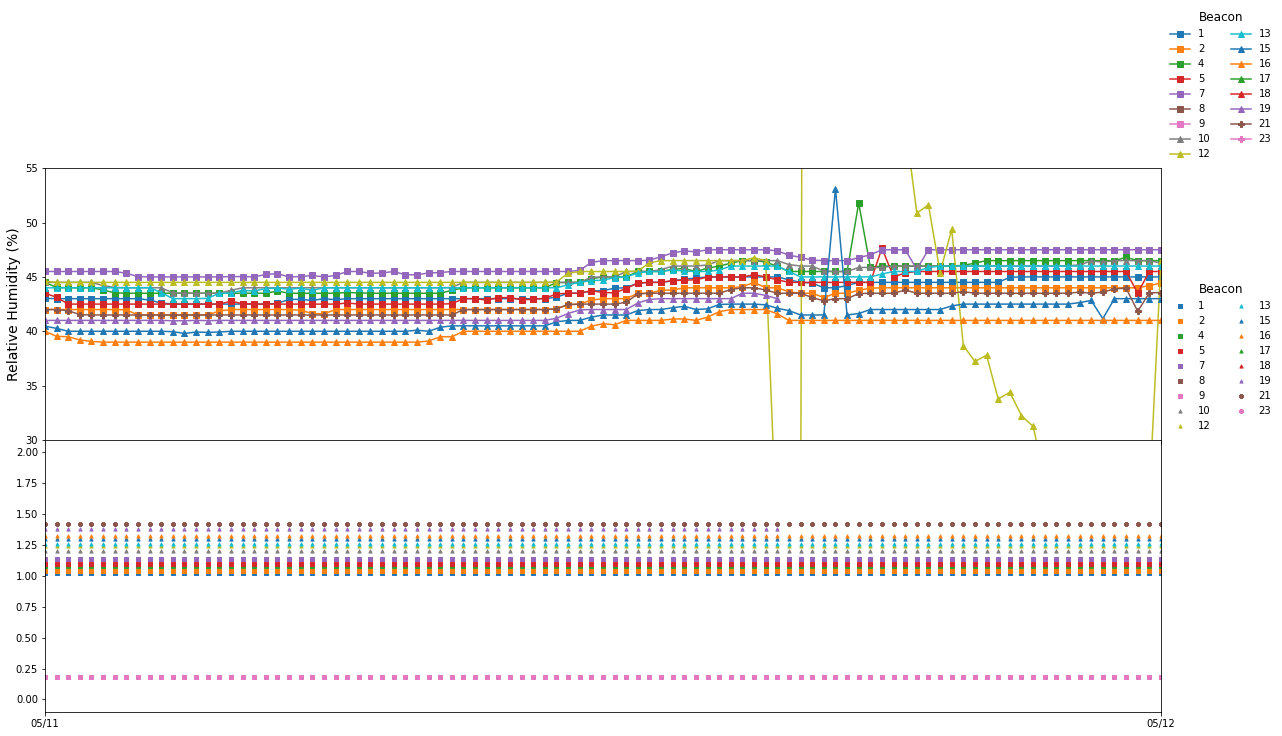

In [19]:
xleft = datetime(2021,5,11)
xright = datetime(2021,5,12)
for var, limits in zip(raw_data.columns,[[],[0,1000],[0,400],[-10,20],[0,400],[0,100],[0,25],[0,1000],[],[20,40],[30,55]]):
    if var not in ["timestamp","beacon"]:
        fig, axes = plt.subplots(2,1,figsize=(20,10),sharex=True,gridspec_kw={"hspace":0})
        for beacon in raw_data["beacon"].unique():
            data_by_beacon = raw_data[raw_data["beacon"] == beacon].set_index("timestamp")
            data_by_beacon = data_by_beacon.resample("15T").mean()
            ax = axes[0]
            ax.plot(data_by_beacon.index,data_by_beacon[var],marker=visualize.get_marker(int(beacon)),label=beacon)

            #ax.set_xlim(left=min(raw_data["timestamp"]),right=max(raw_data["timestamp"]))
            ax.set_xlim(left=xleft,right=xright)
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))

            ax.set_ylabel(visualize.get_pollutant_label(var) + " (" + visualize.get_pollutant_units(var) +")",fontsize=14)
            ax.set_ylim(limits)

            ax.legend(title="Beacon",ncol=2,bbox_to_anchor=(1,1),frameon=False,title_fontsize=12,fontsize=10)
            # operation
            ax = axes[1]
            data_by_beacon["op"] = data_by_beacon[var].notna()
            #print(beacon)
            #print(data_by_beacon["op"])
            ax.scatter(data_by_beacon.index,data_by_beacon["op"]+int(beacon)/50,marker=visualize.get_marker(int(beacon)),s=10,label=beacon)
            # x-axis
            ax.set_xlim(left=xleft,right=xright)
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
            # y-axis
            ax.set_ylim([-0.1,2.1])
            # legend
            ax.legend(title="Beacon",ncol=2,bbox_to_anchor=(1,1),frameon=False,title_fontsize=12,fontsize=10)
        
        plt.show()
        plt.close()

# Pre-Calibration
With access to higher-grade instruments, we start to look at the possibility of post-calibrating the sensors to get more-reliable results.

In [20]:
from src.calibration import calibrate

import math
import statsmodels.api as sm

## Process
The process for post-calibration is as follows:
1. **Determine Offset** (if any): Some of the sensors have a baseline that is a few (or more) units off from the true baseline. An initial _background_ calibration event should be done/used to correct the sensor to the right baseline. The offsets are saved in a file that is used when reading in the values from a certain study. 
2. **Linear Model**: 

## Experiment Details
Here are the relevant notes from the calibration experiments:
1. Experiment 1
 - **Start**: datetime(2021,5,10,14,5,0)
 - **End**: datetime(2021,5,10,23,59,0)
 - **Beacons**: [1,2,4,5,6,7,10,11,12,13,14,15,16,19,21]
 - **Events**:
     - 14:15 - 14:25: CO2 cylinder open
     - 14:25 - 14:40: Candle burning
     - 14:40 - 14:50: CO2 cylinder open
     - 14:50 - 15:05: candle burning
 - **Notes**:
     - B26 added at 14:36
2. Experiment 2
 - **Start**: datetime(2021,5,11,16,30,0)
 - **End**: datetime(2021,5,11,17,30,0)
 - **Beacons**: [1,2,4,5,6,7,10,11,12,13,14,15,16,19,21]
 - **Events**:
     - 16:35 - 17:10: Candle and paper burning
     - 16:40 - 16:55: CO2 cylinder open

### Defining Calibration Object
We use the `Calibration` class from the UTx000 Project.

In [100]:
c = calibrate.Calibration(datetime(2021,5,10,14,5,0),datetime(2021,5,10,23,59,0),"../data/",study="wcwh_pilot",study_suffix="wcwh_s21",)

### Beacon Data
We grab the beacon data.

In [101]:
beacon = import_beacon_data(beacon_list=[1,2,4,5,6,7,10,11,12,13,14,15,16,19,21],start_time=c.start_time,end_time=c.end_time,resample_rate=1)
beacon.set_index("timestamp",inplace=True)

### Reference Instrument Data
All data are saved as dataframes in a dictionary indexed by the pollutant type

In [103]:
# experiment 1 offset
#t_offset = datetime(2021,5,10,14,5,0) - datetime(2021,5,10,12,58,22)
# experiment 2 offset
t_offset = datetime(2021,5,11,16,30,0) - datetime(2021,5,11,15,23,0)

In [104]:
ref = {}
for pollutant, f in zip(["pm_number","pm_mass","no2","co2","co"],[c.get_pm_ref,c.get_pm_ref,c.get_no2_ref,c.get_co2_ref,c.get_zero_baseline]):
    print("reading for", pollutant)
    if pollutant[:3] in ["no2","pm_","co2"]:
        ref[pollutant] = f(file=f"{pollutant}_{c.date}.csv",resample_rate=1,minute_offset=t_offset.seconds/60)
    else:
        ref[pollutant] = f(file=f"{pollutant}_{c.date}.csv",resample_rate=1)

reading for pm_number
reading for pm_mass
reading for no2
reading for co2
reading for co


## Inspection
Some simple functions to inspect measurements

### Reference Measurements

In [35]:
#c.inspect(ref["pm_concentration"][["PM_2p5"]])
#c.inspect(ref["co2"])
#c.inspect(beacon[["PM_N_2p5","Beacon"]],timeseries=False)

### Beacon Measurements

In [36]:
##bb = "05"
##df = pd.read_csv(f"../data/raw/utx000/beacon/B{bb}/sensirion/b{bb}_2021-01-12.csv",index_col=0,parse_dates=True)
##c.inspect(df[["CO2"]])

## Calibration of Pollutants with Reference
In this section, we take a look at correcting the low-cost sensors to the reference machines in three ways:
1. Constant/Offset
2. Linear Regression
3. Random Forest

The following sections are first broken down by pollutant and then by method.

In [37]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

### Details
The cells below should be edited to correspond to the pollutant of interest:
- **no2**: [SPEC DGS NO2](https://www.spec-sensors.com/wp-content/uploads/2017/01/DGS-NO2-968-043_9-6-17.pdf)
- **co**: [SPEC DGS CO](https://www.spec-sensors.com/wp-content/uploads/2017/01/DGS-CO-968-034.pdf)
- **co2**:

In [363]:
pollutant = "co"

### Non-Responsive Beacons
The ```get_reporting_beacons``` functions determines which of the beacons that was included in the calibration event are not shown in the following figures because of issues related to power, sensor connection, or VPN connection.

In [364]:
missing, reporting = c.get_reporting_beacons(beacon,pollutant)

Missing data from: []


### Time Series Comparison

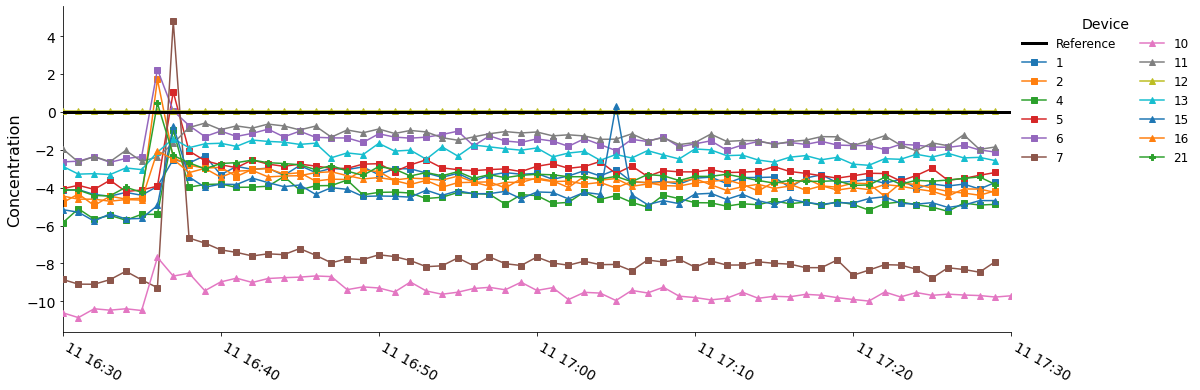

In [38]:
c.compare_time_series(ref[pollutant],beacon[[pollutant,"beacon"]])

### Comparing Histograms
Now we look at each individual beacon and compared the histograms

In [70]:
c.compare_histogram(ref[pollutant],beacon[[pollutant,"beacon"]],bins=np.arange(0,4000,500))

### Constant/Offset
The simplest method, and one that might show promise for this sensor, is simply to offset the measurement by a constant. We start by looking at the differences between each beacon with an NO2 sensor and the reference machine.

In [71]:
offset = c.offset(ref, beacon, pollutant, pollutant, save_to_file=True, show_corrected=False)

### Linear Model

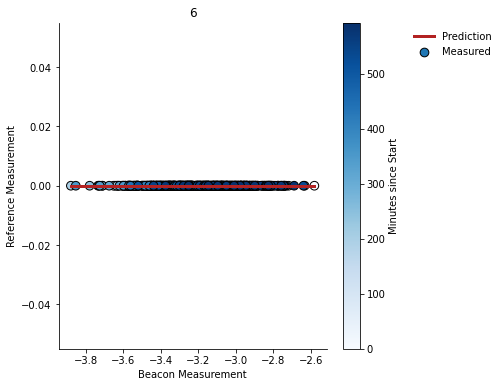

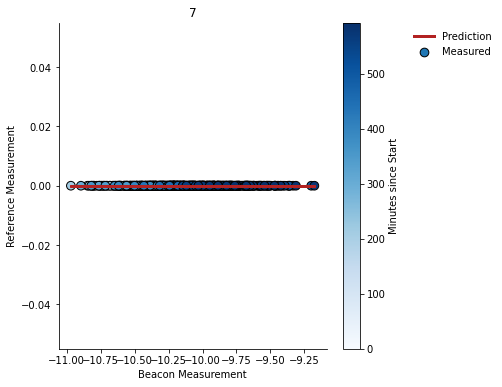

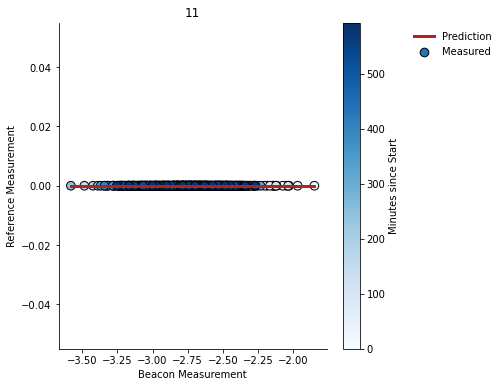

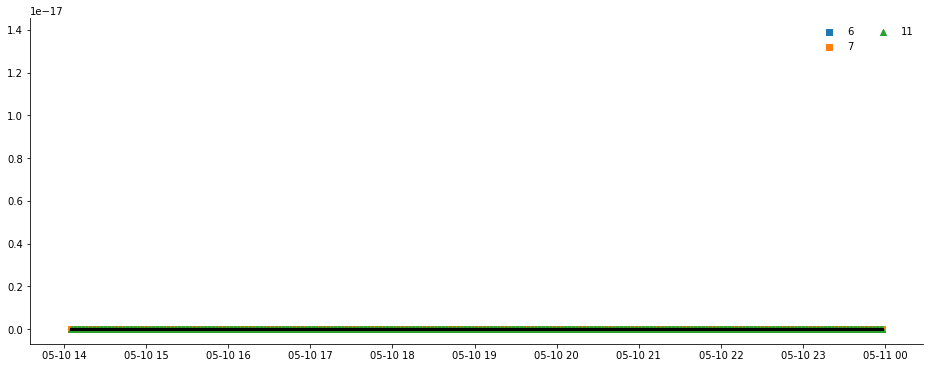

In [343]:
m = c.linear_regression(ref, beacon, pollutant, pollutant,verbose=False,save_to_file=True,show_plot=True,show_corrected=True)

## Particulate Matter
We look at the calibration of PM in a different set of cells due to the reference format. 

In [105]:
size = "2p5"
measurement = "mass"

### Time Series Comparison

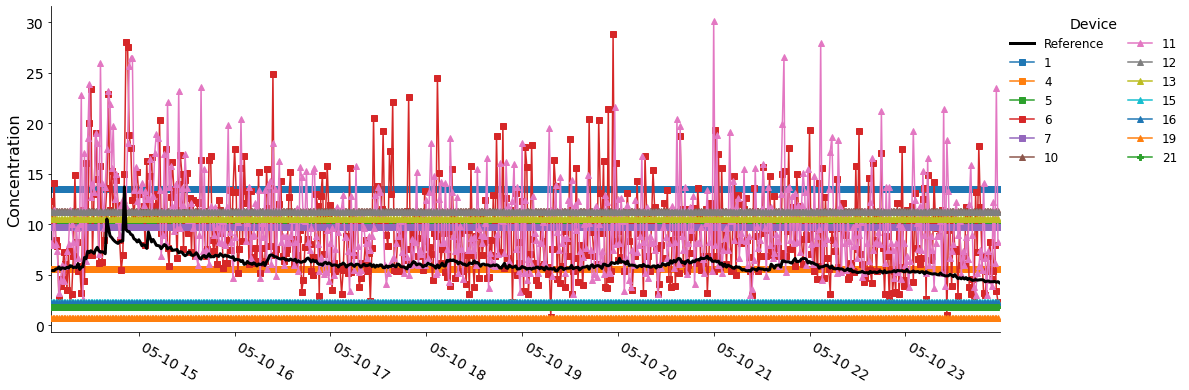

In [106]:
c.compare_time_series(ref[f"pm_{measurement}"][[f"pm{size}"]],beacon[[f"pm{size}_{measurement}","beacon"]])

### Histogram Comparison

In [107]:
#c.compare_histogram(ref[f"pm_{measurement}"][[f"pm{size}"]],beacon[[f"pm{size}_{measurement}","beacon"]],bins=np.arange(0,21,1))

Based on the results, it does not seem like there is a good constant offset that we can apply to correct the data. In fact, many of the beacons seem to exhibit the same pattern and are colored accordingly.

### Constant/Offset

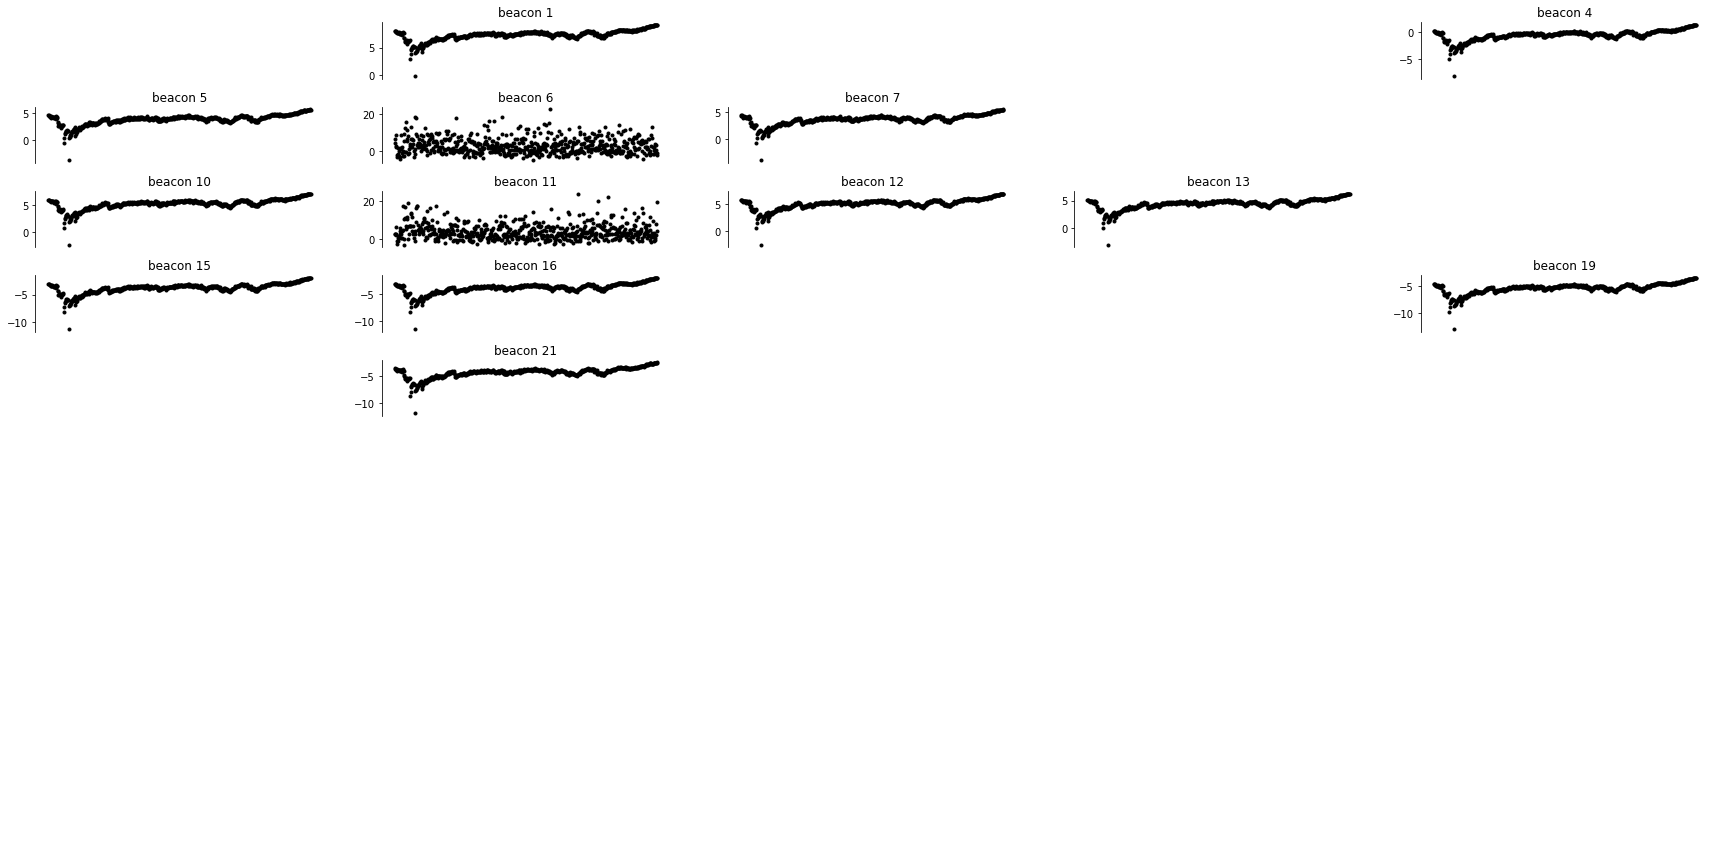

In [108]:
pm_mass = ref[f"pm_{measurement}"]
pm_mass[f"concentration"] = pm_mass[f"pm{size}"]
ref[f"pm_{measurement}"] = pm_mass
pm_offset = c.offset(ref, beacon, f"pm_{measurement}", f"pm{size}_{measurement}",save_to_file=False,show_corrected=False)

### Linear Model

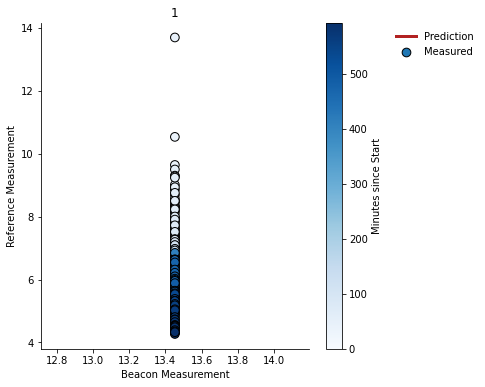

Error with data.


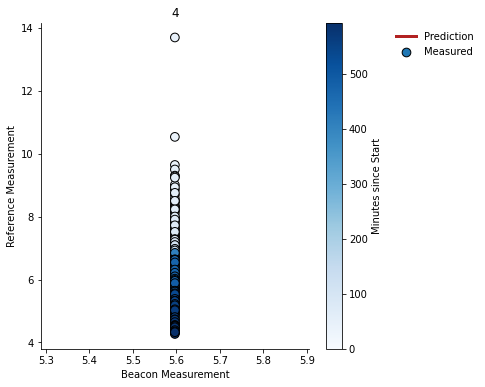

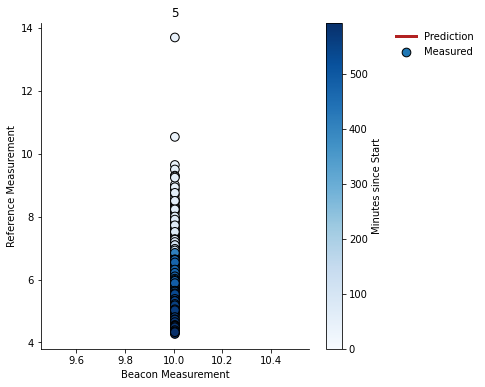

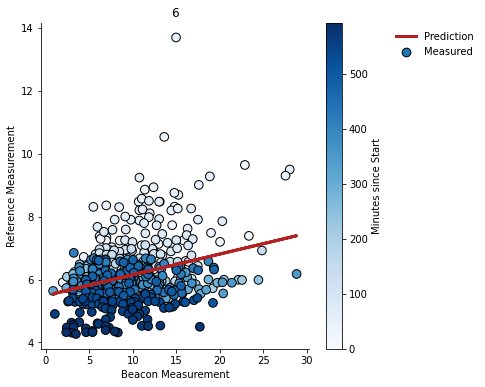

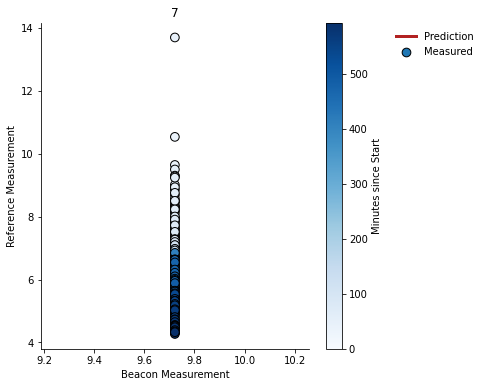

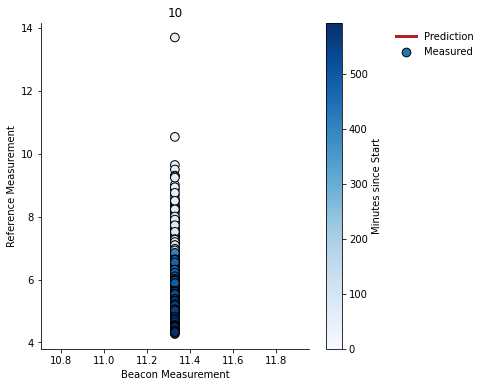

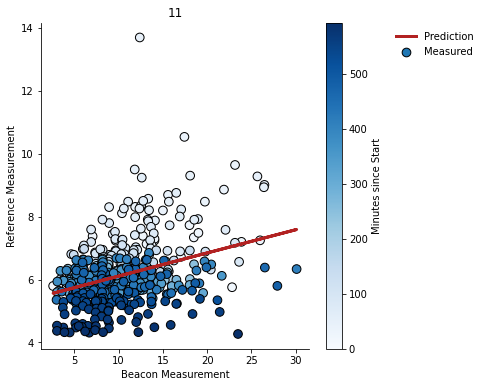

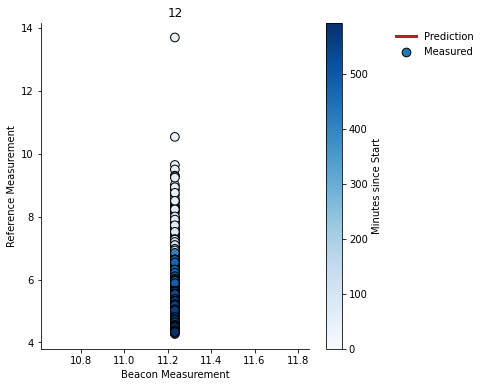

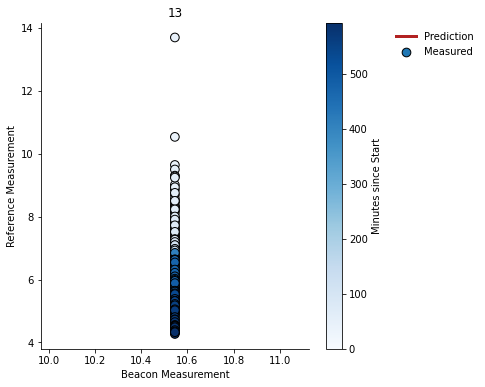

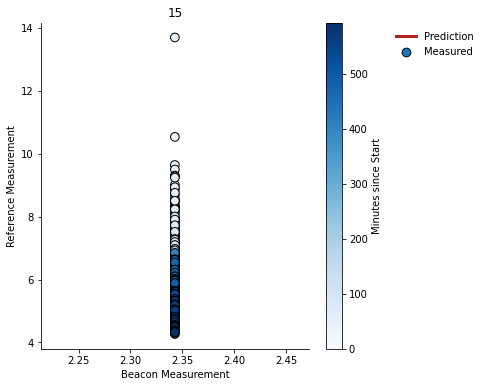

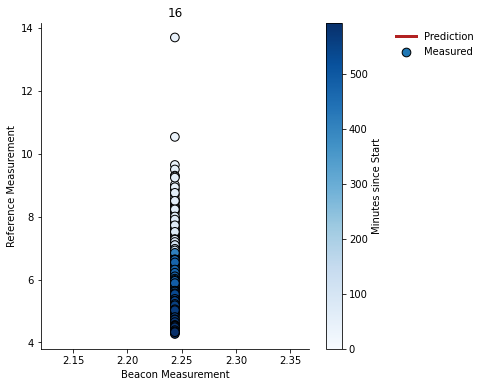

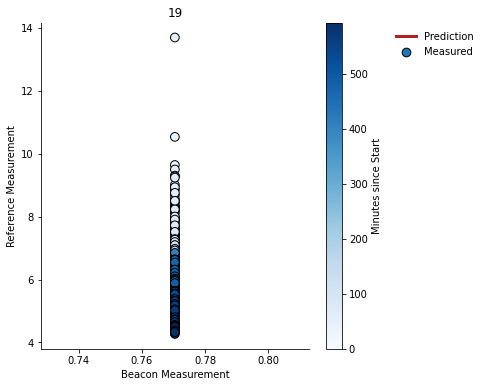

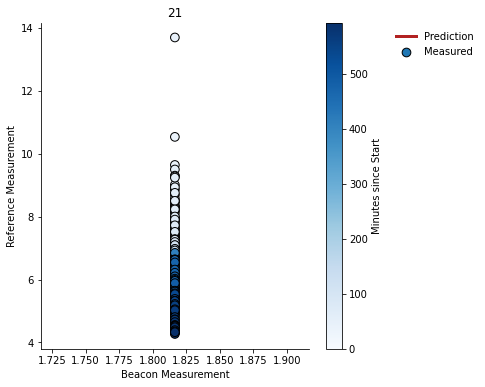

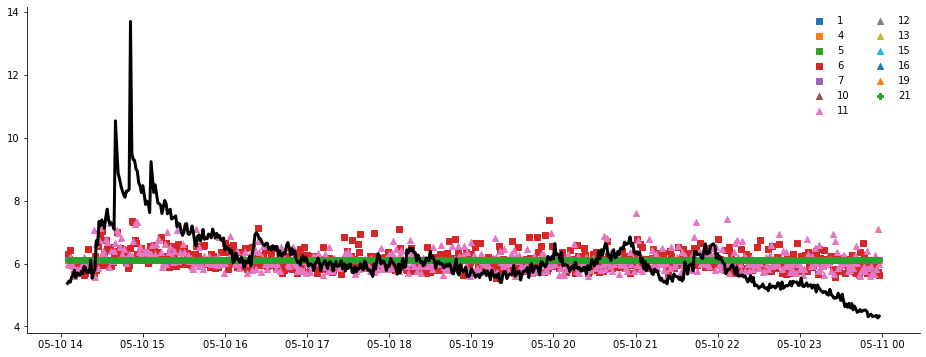

In [88]:
pm_mass = ref[f"pm_{measurement}"]
pm_mass["concentration"] = pm_mass[f"pm{size}"]
ref[f"pm_{measurement}"] = pm_mass
pm_lm = c.linear_regression(ref, beacon, f"pm_{measurement}", f"pm{size}_{measurement}",verbose=False,save_to_file=False,show_plot=True,show_corrected=True)

##### Good Beacons
Now we look at how the "better" sensors performed before and after the zeroing.

In [49]:
no2_test_good = calibrate.Calibration(c.start_time,c.start_time + timedelta(hours=2),"../data/")
no2_test_good_beacon = no2_test_good.get_beacon_data([1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 25, 28, 29, 30, 31, 32, 34, 36, 38, 40, 44, 46, 48])

Plotting

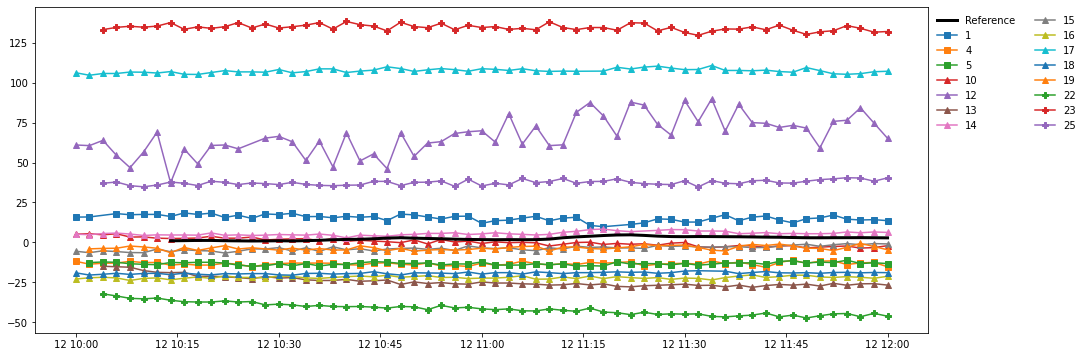

In [50]:
no2_test_good.compare_time_series(ref["no2"],no2_test_good_beacon[["no2","beacon"]])

### Linear Regression
We can run linear regression for each of the beacons to determine how we can best correct our data.

KeyError: '01'

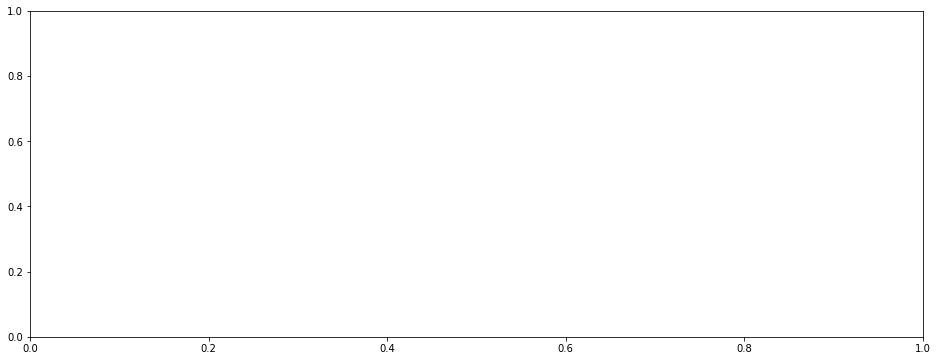

In [56]:
m = c.linear_regression(ref, beacon, "no2", "no2",verbose=False,save_to_file=True,show_plot=True,show_corrected=True)

### Random Forest
Random forests have shown success in recent articles calibrating low cost sensors.

## Particulate Matter - Mass
The [Sensirion SPS30](https://www.sensirion.com/fileadmin/user_upload/customers/sensirion/Dokumente/9.6_Particulate_Matter/Datasheets/Sensirion_PM_Sensors_SPS30_Datasheet.pdf) PM sensor is capable of measuring PM1, PM2.5, and PM10, but we focus on PM2.5 in this section, however the values are easily changed by swapping the following cell to the appropiate value.

In [33]:
# set size to one of ["1","2p5","10"] for the corresponding size
size = "1"

Specifications regarding the mass concentrations for the SPS30 sensor are below:

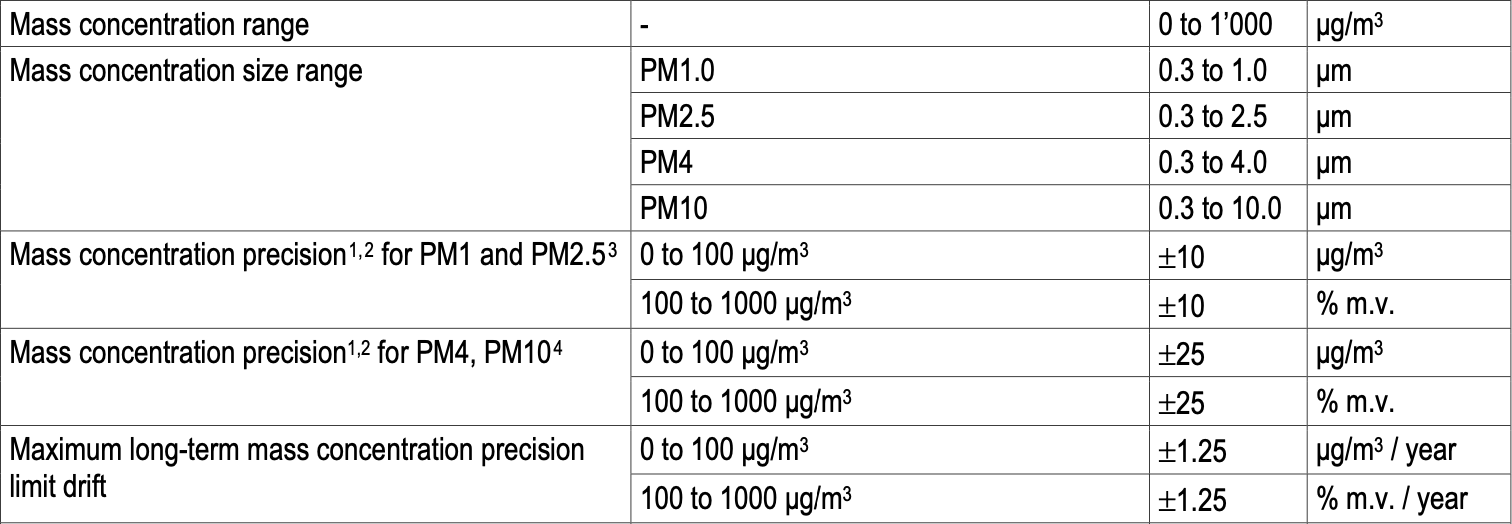

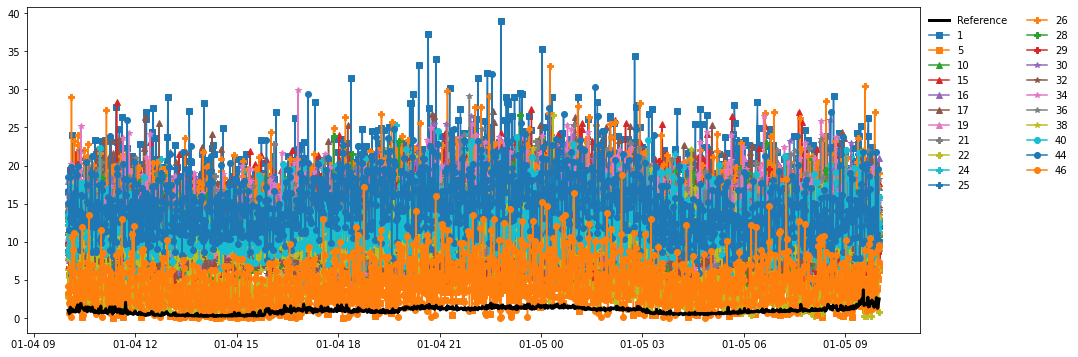

In [25]:
c.compare_time_series(ref["pm_concentration"][[f"pm{size}"]],beacon[[f"pm{size}_mass","beacon"]])

In [54]:
missing_pm, reporting_pm = c.get_reporting_beacons(beacon,f"pm{size}_mass")

Missing data from: [35]


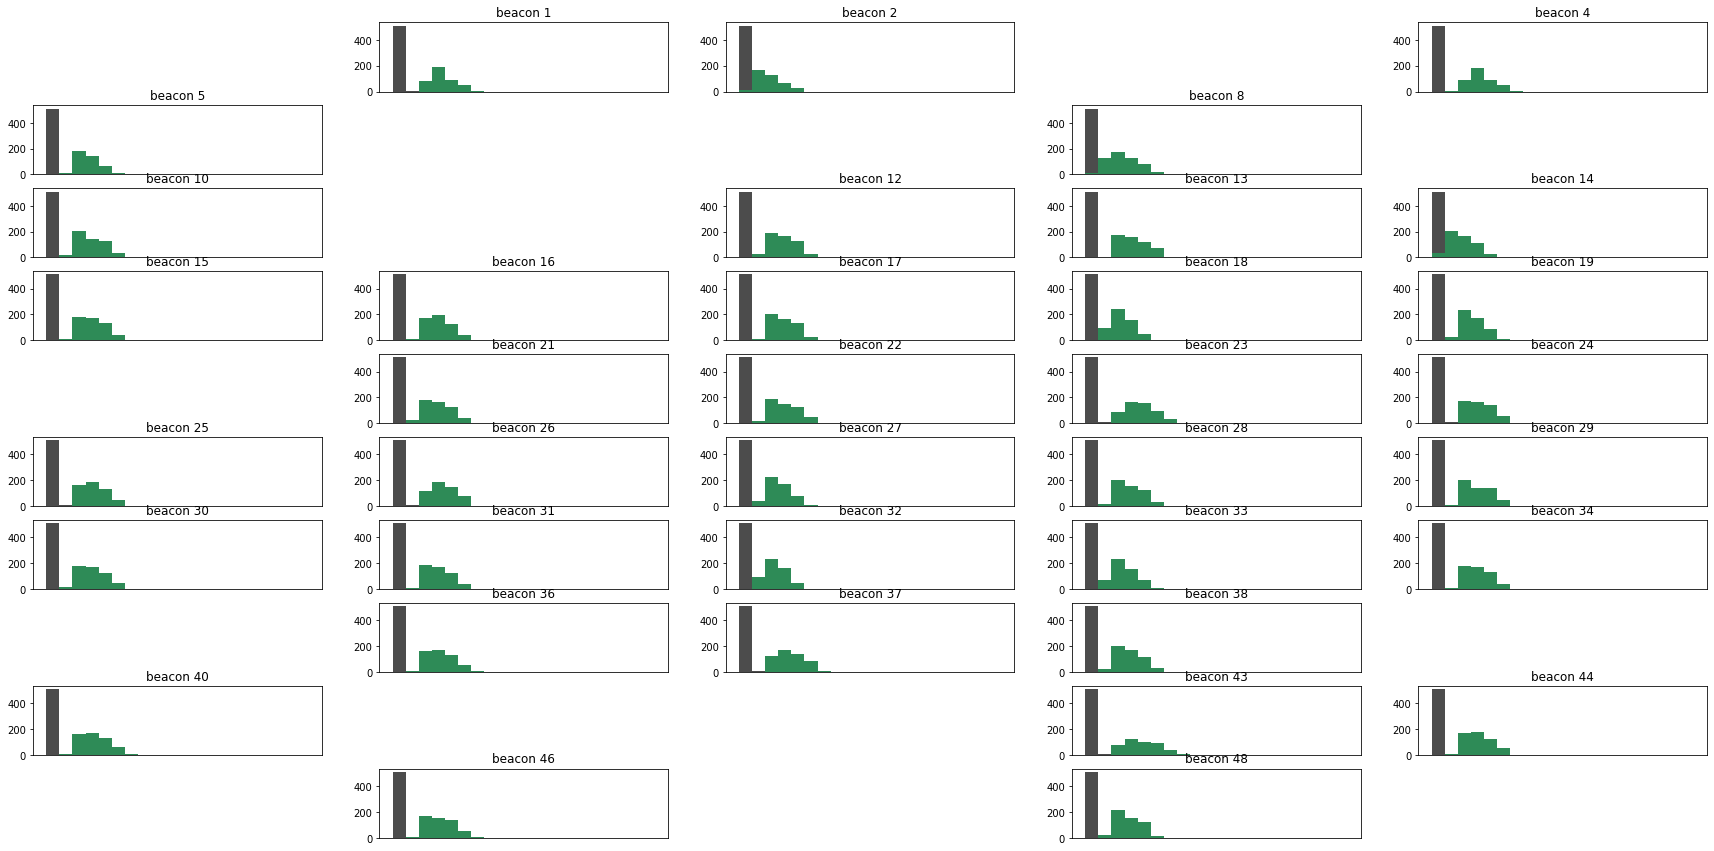

In [55]:
c.compare_histogram(ref["pm_concentration"][[f"pm{size}"]],beacon[[f"pm{size}_mass","beacon"]],bins=np.arange(0,21,1))

### Constant/Offset
Based on the above figure, it seems quite clear that a few of the PM sensors have a baseline a few units above zero. So in addition to adding a calibration algorithm, we must include a constant correction. 

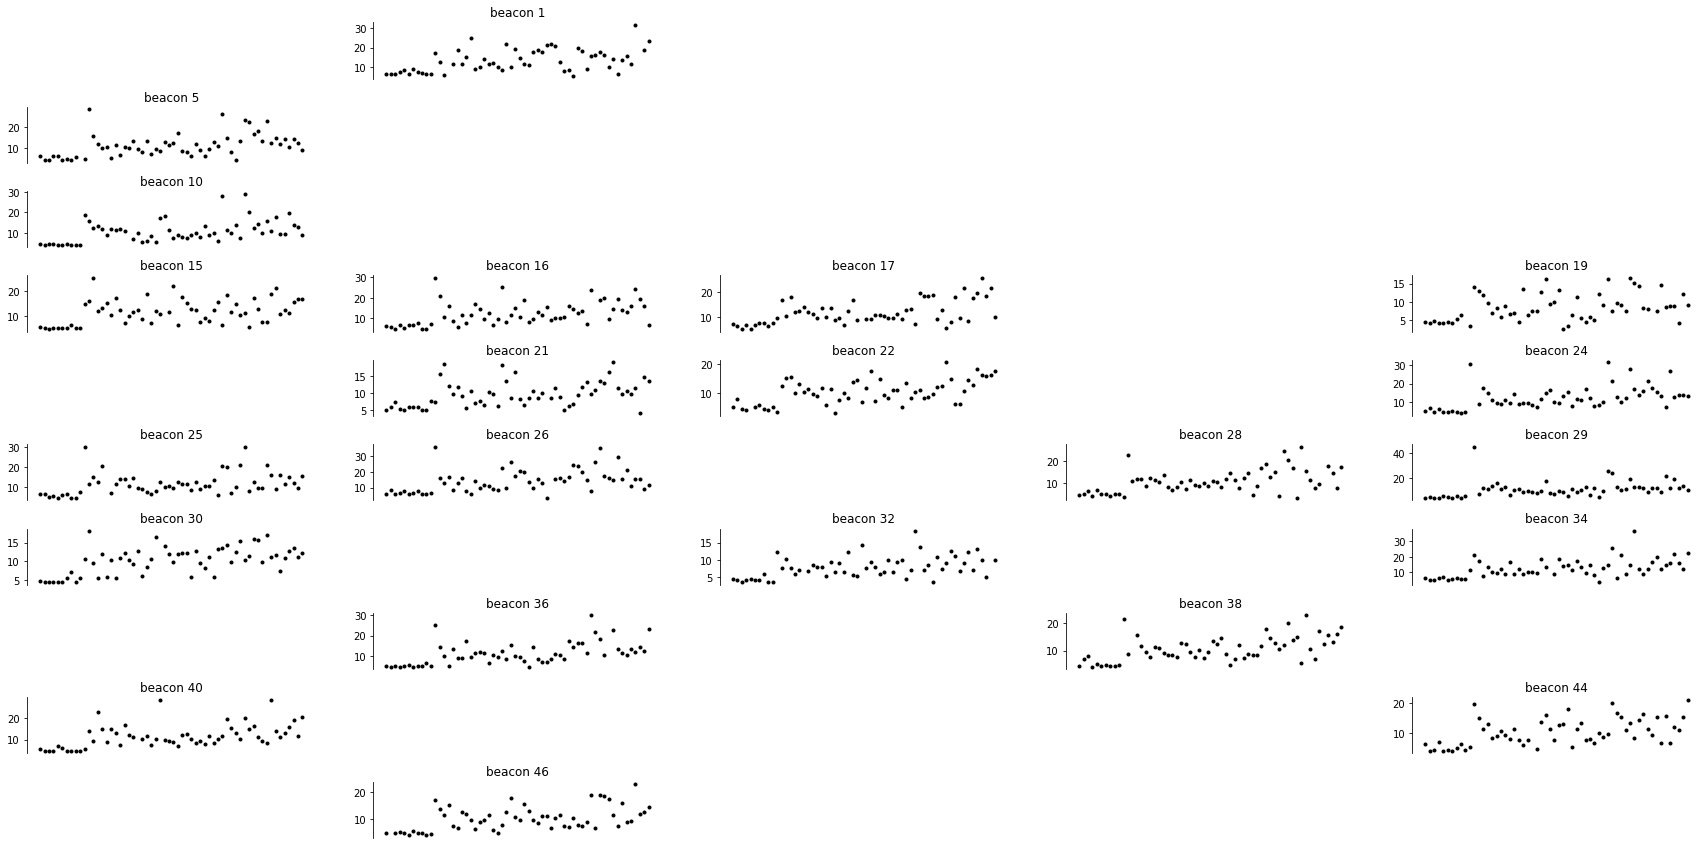

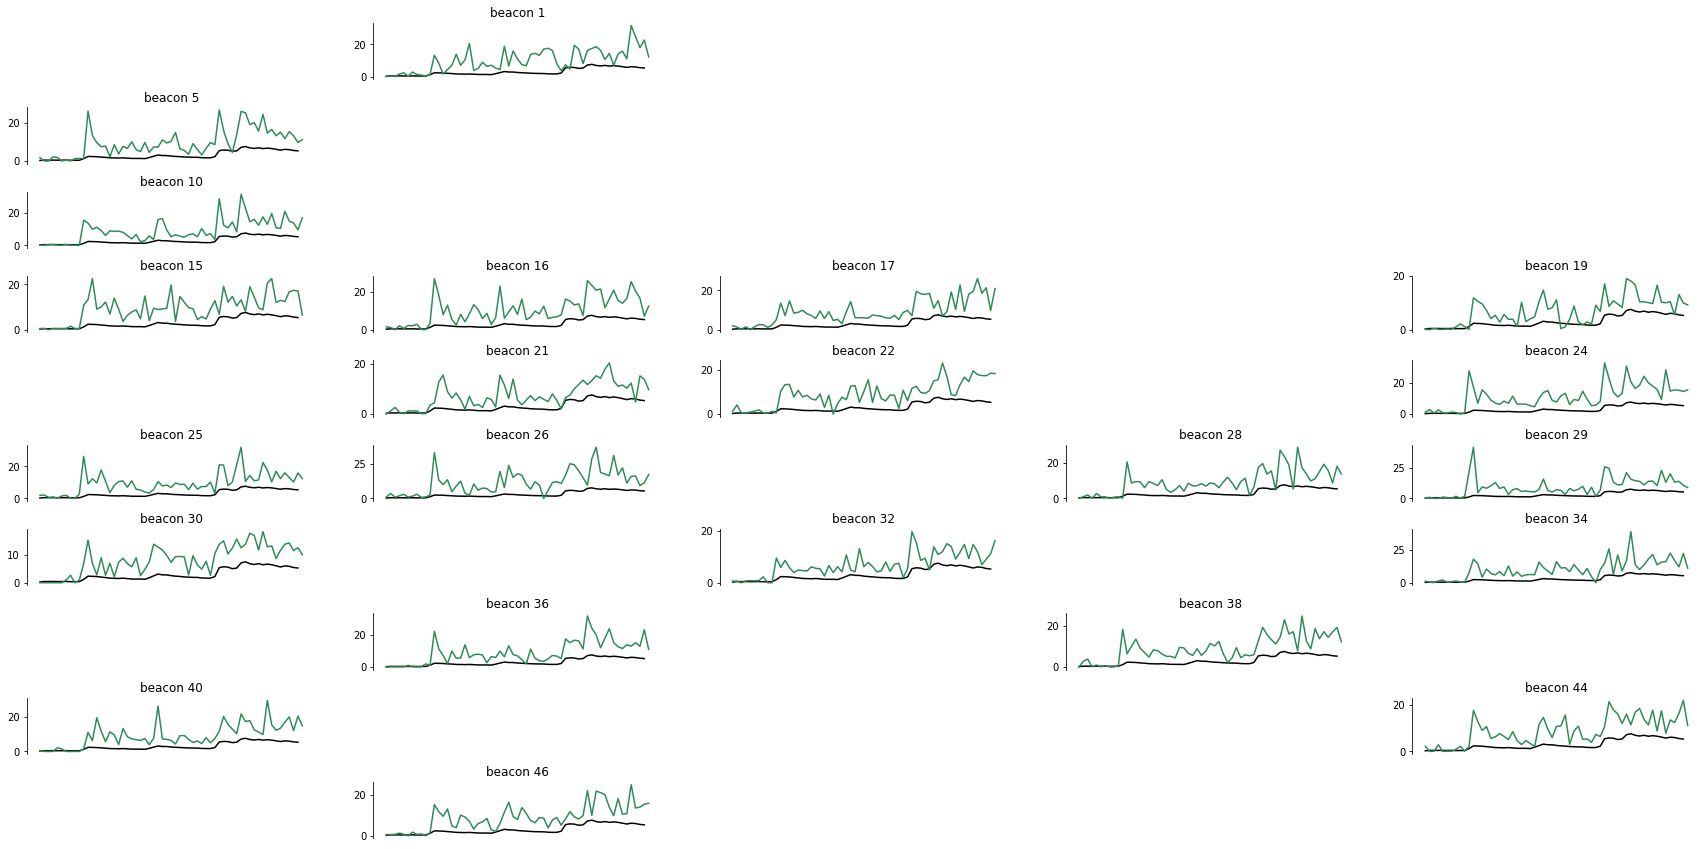

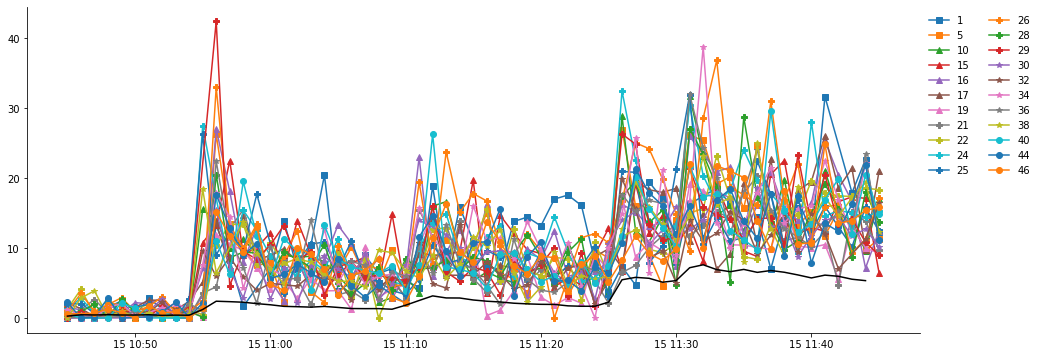

In [9]:
pm_mass = ref["pm_concentration"]
pm_mass["concentration"] = pm_mass[f"pm{size}"]
ref["pm_concentration"] = pm_mass
pm_mass_offset = c.offset(ref, beacon, "pm_concentration", f"pm{size}_mass",save_to_file=False,show_corrected=True)

### Linear Regression

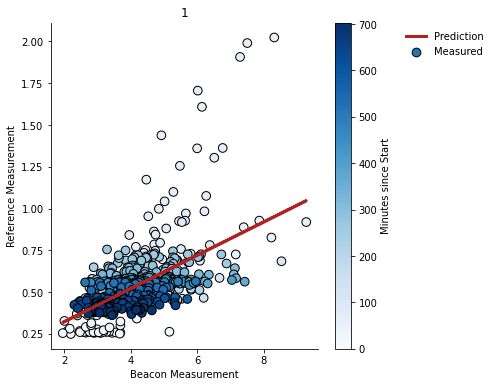

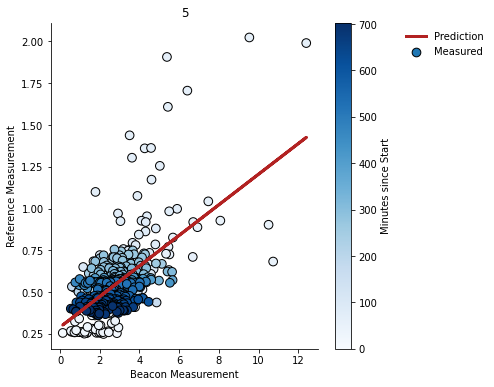

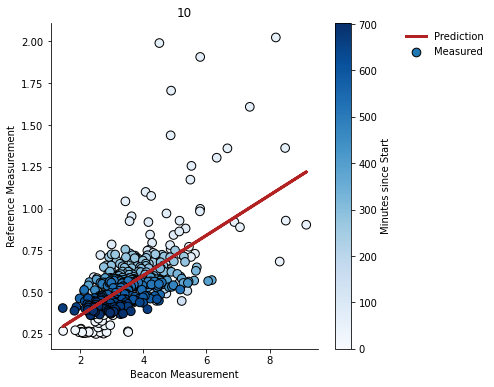

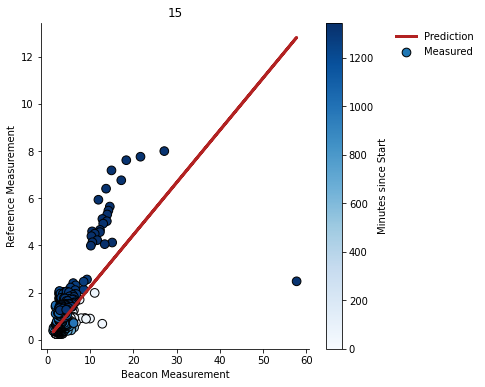

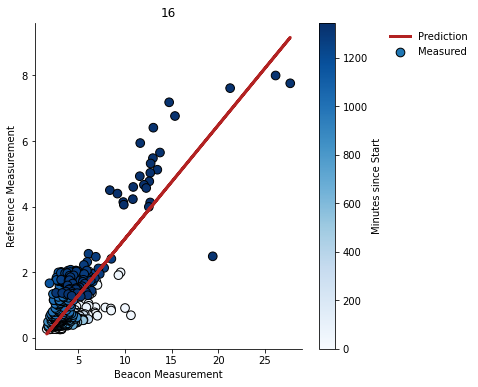

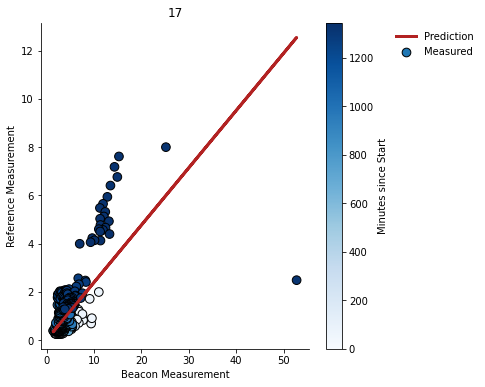

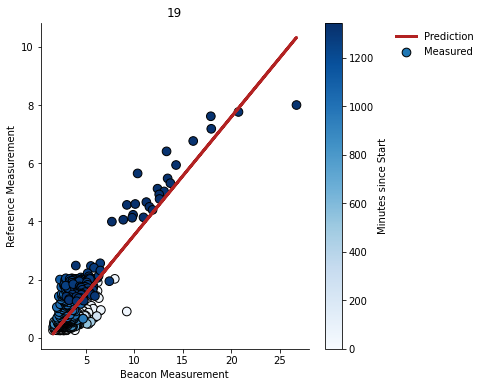

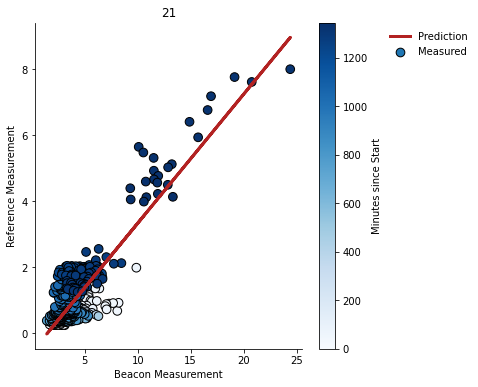

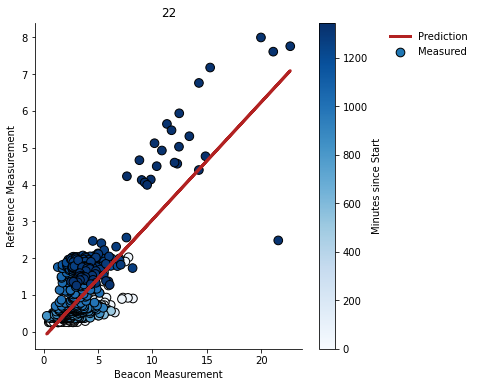

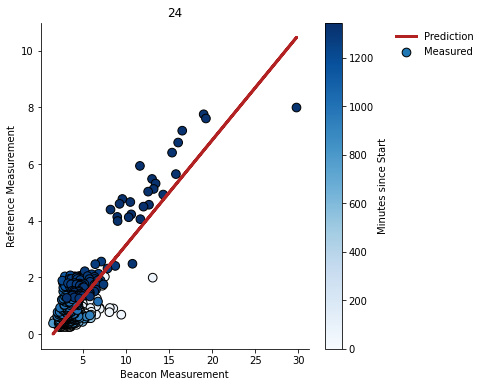

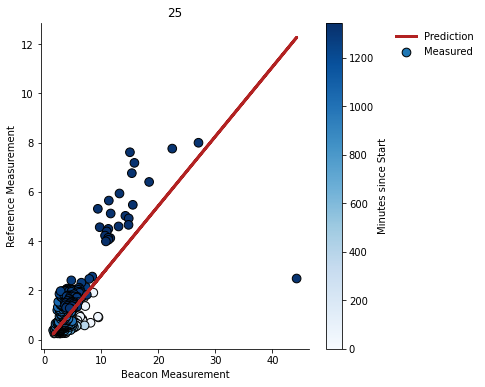

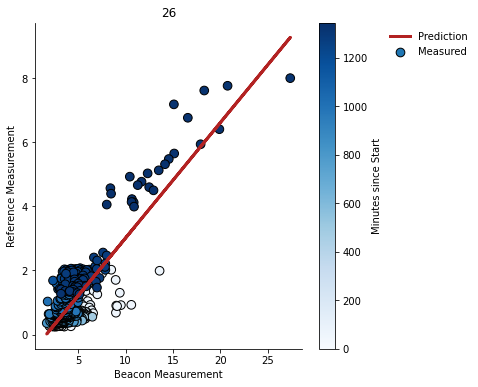

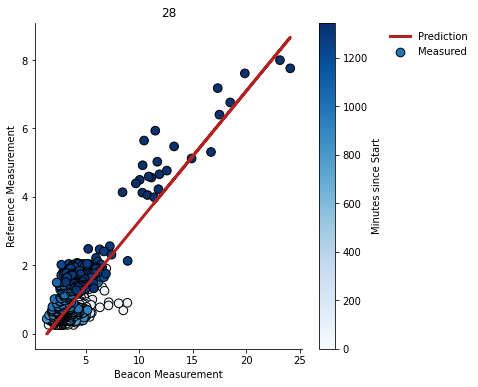

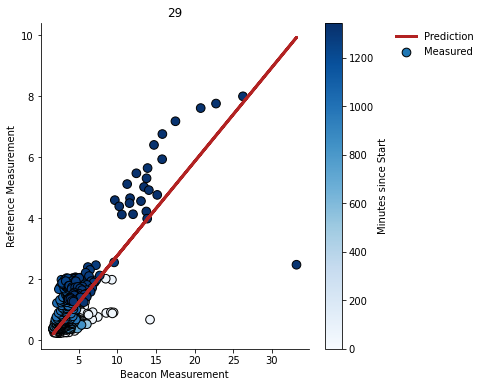

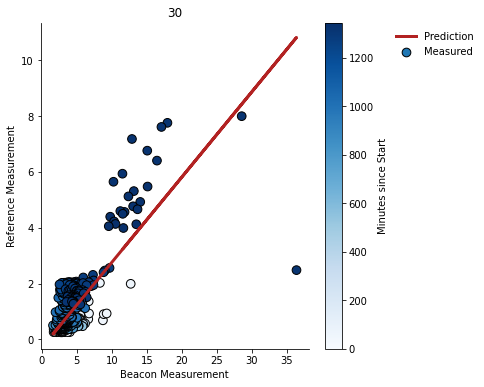

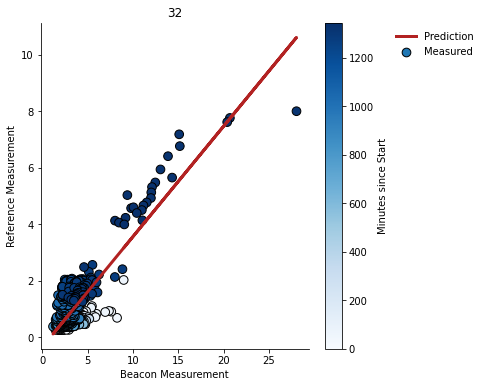

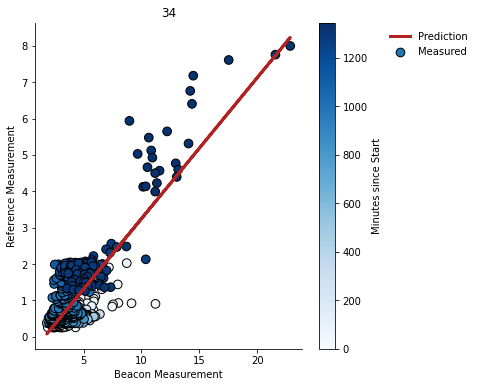

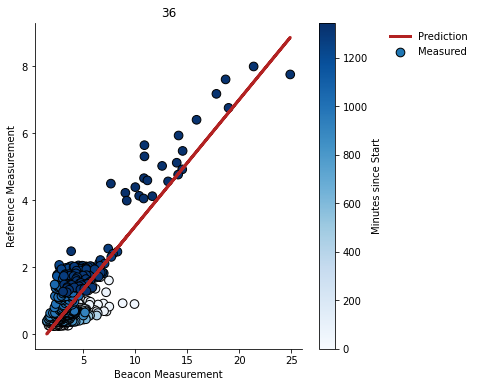

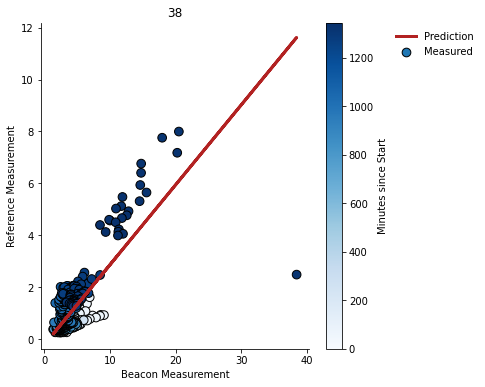

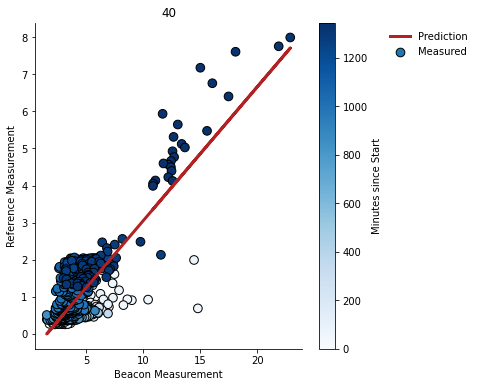

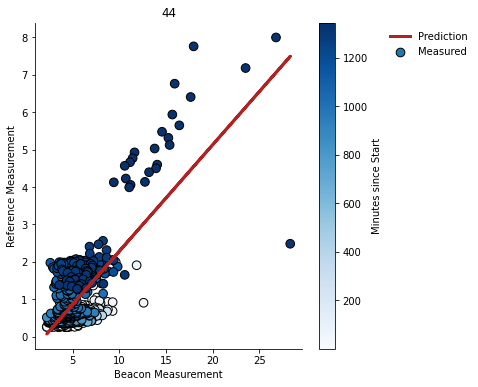

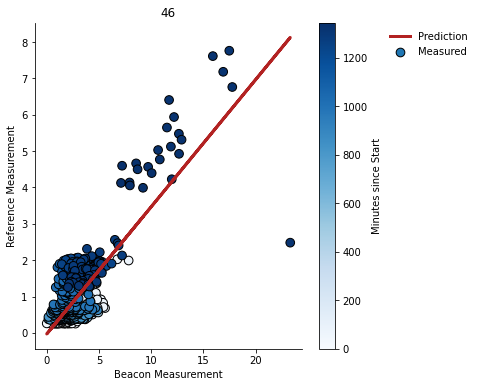

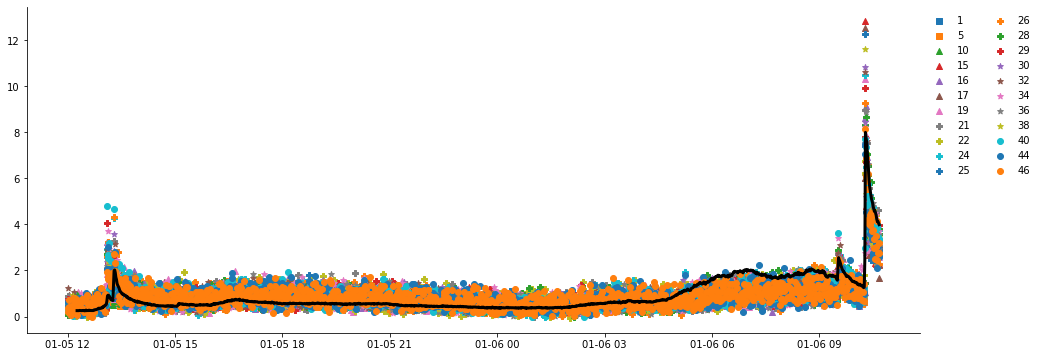

In [34]:
pm_mass = ref["pm_concentration"]
pm_mass["concentration"] = pm_mass[f"pm{size}"]
ref["pm_concentration"] = pm_mass
pm_mass_lm = c.linear_regression(ref, beacon, f"pm_concentration", f"pm{size}_mass",verbose=False,save_to_file=True,show_plot=True,show_corrected=True)

### PM Mass Behavior
Here we take a look at the beacons that have misbehaving SPS30 sensors.

##### Bad Sensors
The bad sensors seem to be 4 and 13.

In [57]:
pm_test_bad = calibrate.Calibration(datetime(2020,12,30,12,40,0),datetime(2021,1,6,10,40,0),"../data/")
pm_test_bad_beacon = pm_test_bad.get_beacon_data([4, 13])

Plotting

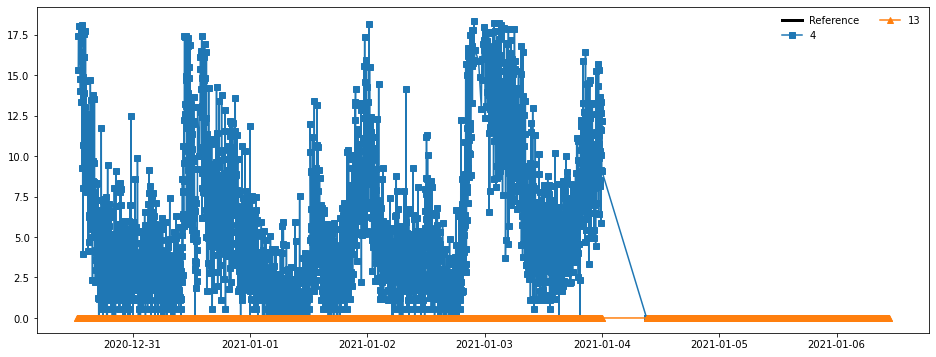

In [58]:
pm_test_bad.compare_time_series(ref["pm_number"][[f"pm{size}"]],pm_test_bad_beacon[[f"pm{size}_number","beacon"]])

It appears that BB04 was working for a little bit, but after a pulled data from them and rebooted, it stopped reporting measurements. BB13 just isn't reporting anything.

## Particulate Matter - Number
Now we look at the number concentrations from [Sensirion SPS30](https://www.sensirion.com/fileadmin/user_upload/customers/sensirion/Dokumente/9.6_Particulate_Matter/Datasheets/Sensirion_PM_Sensors_SPS30_Datasheet.pdf) PM sensor to see if the relationship to the reference machine is stronger - the specifications on the number concentrations:

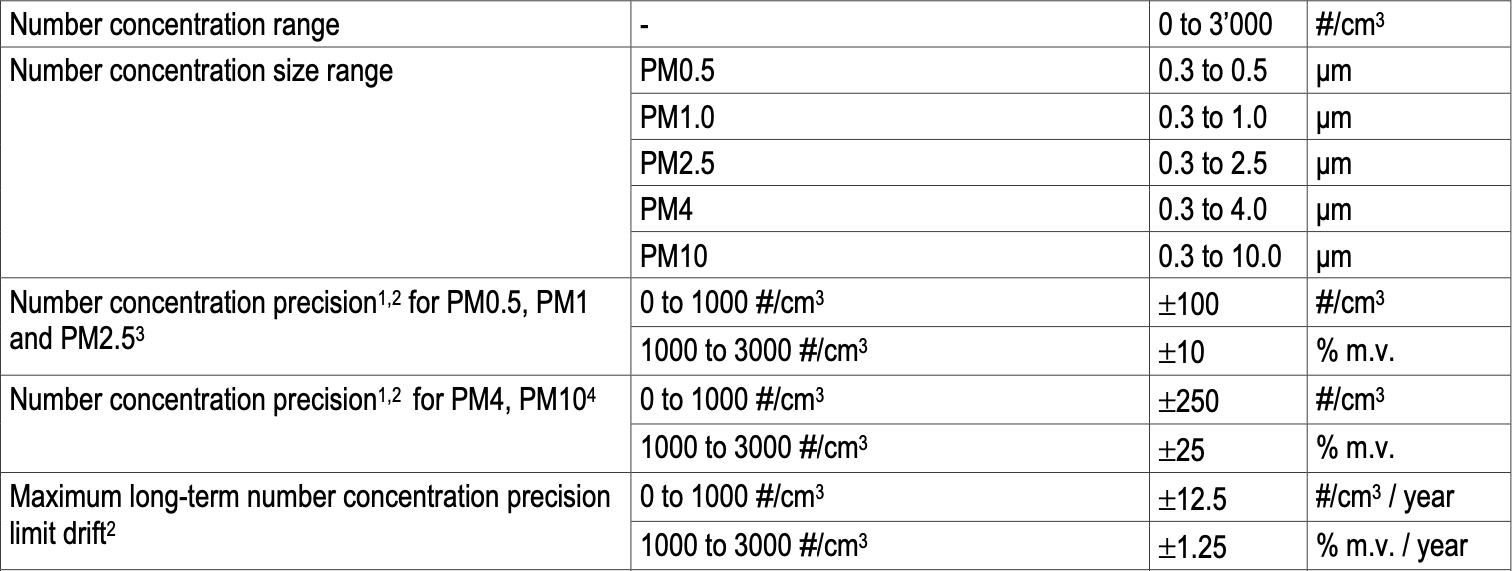

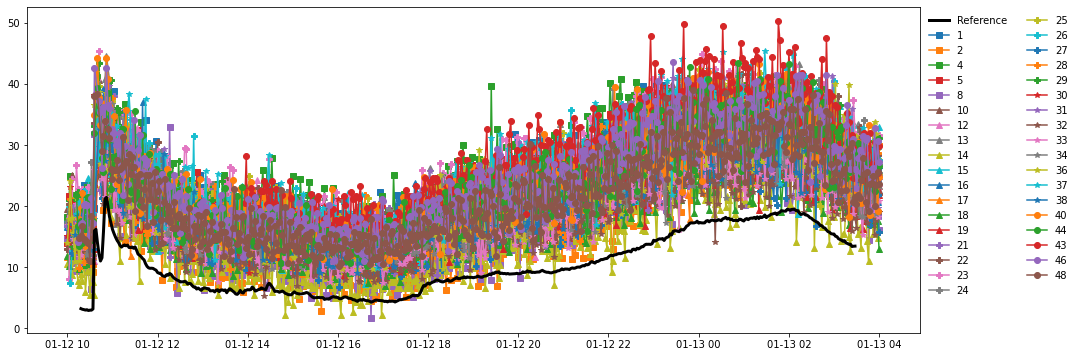

In [59]:
c.compare_time_series(ref["pm_number"][[f"pm{size}"]],beacon[[f"pm{size}_number","beacon"]])

### Constant/Offset
Based on the above figure, the number concentrations seems to be quite accurate, but some of the beacons are reading a few units higher. We can use the ```offset``` method to correct those sensors.

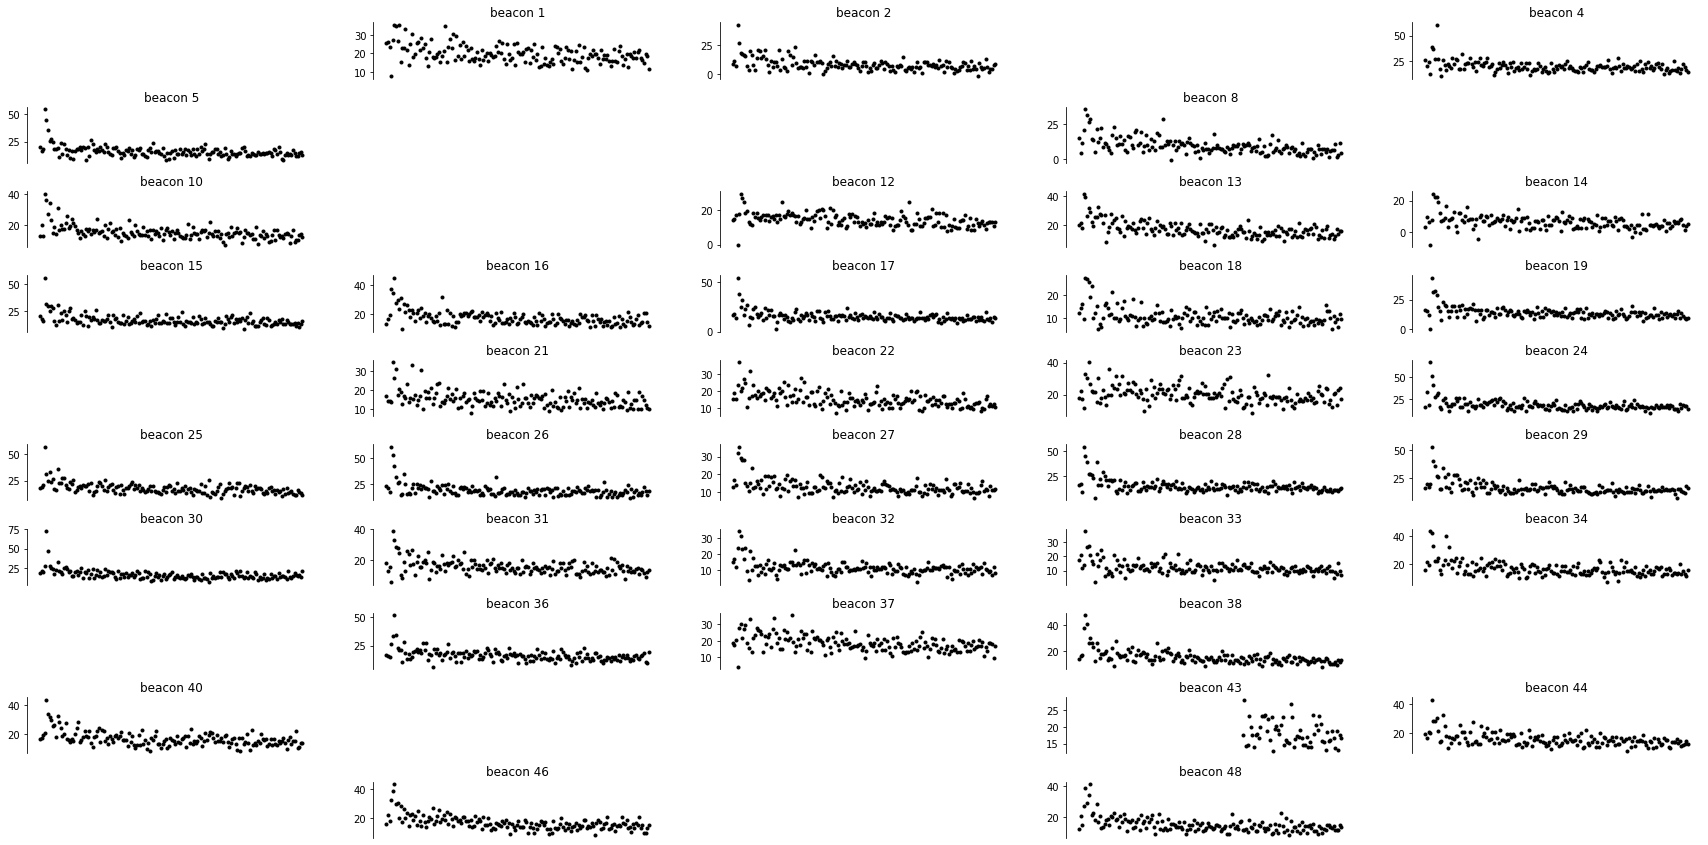

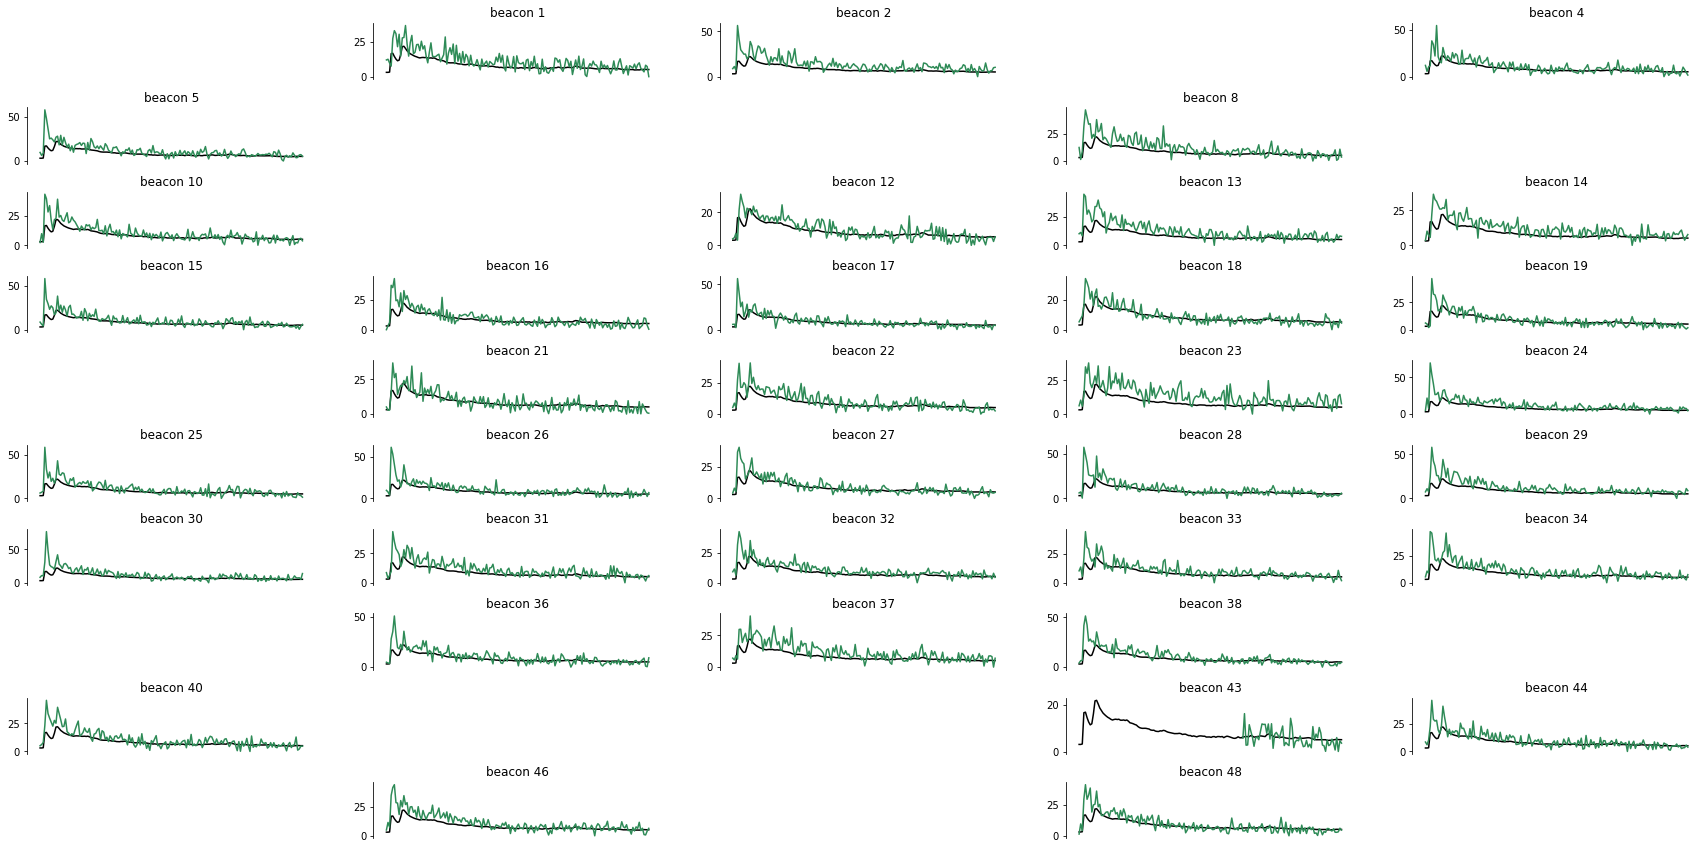

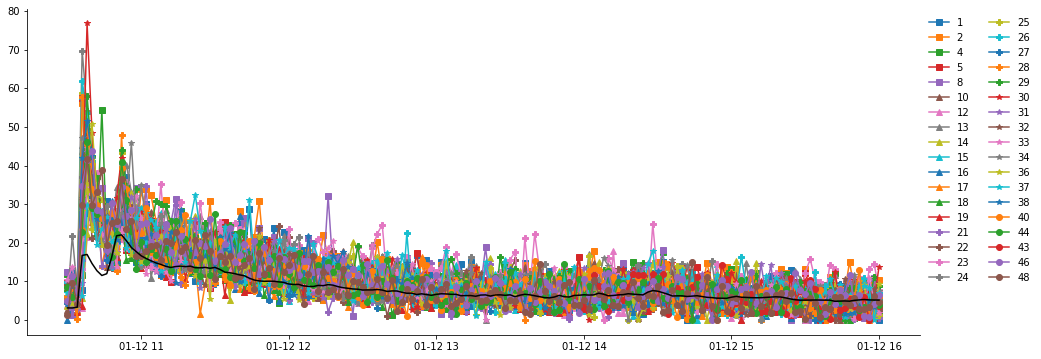

In [85]:
pm_number = ref["pm_number"]
pm_number["concentration"] = pm_number[f"pm{size}"]
ref["pm_number"] = pm_number
pm_number_offset = c.offset(ref, beacon, "pm_number", f"pm{size}_number",save_to_file=True,show_corrected=True)

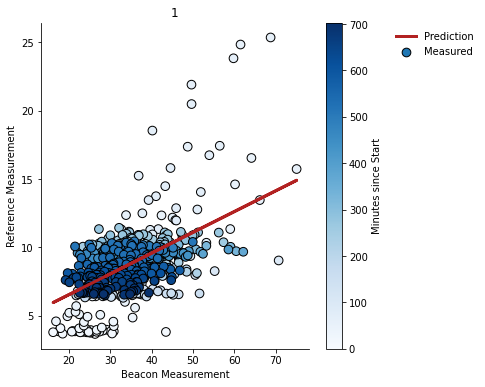

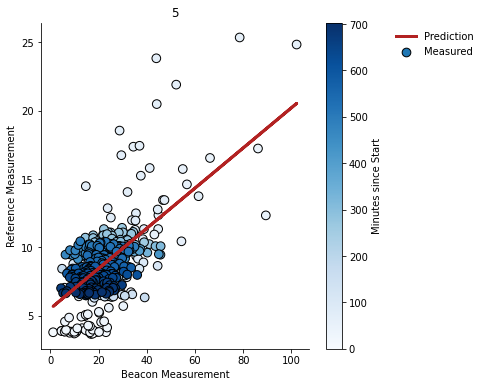

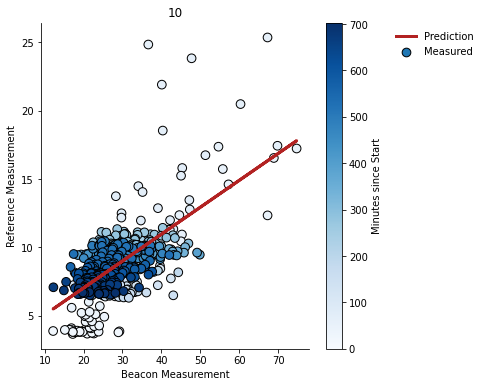

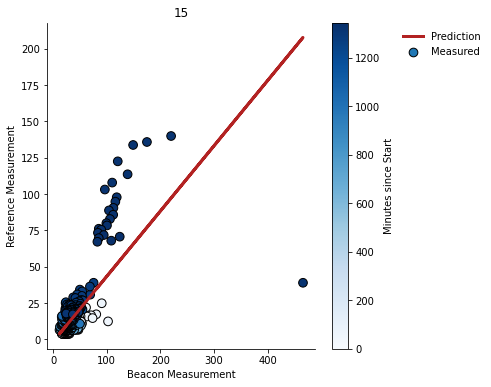

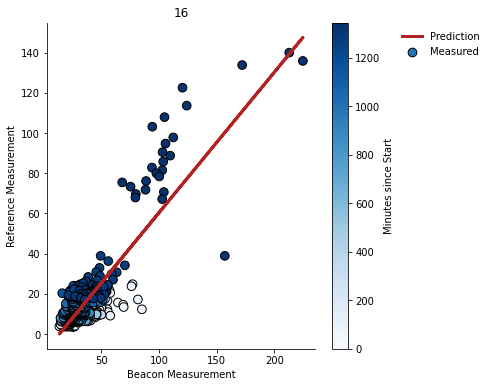

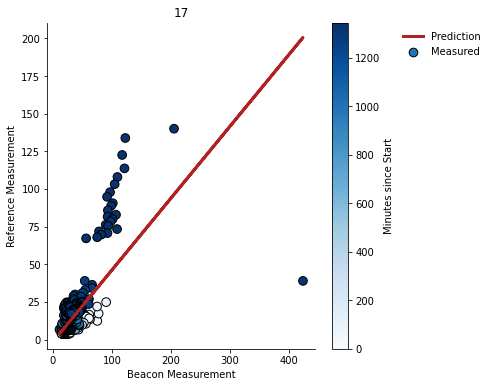

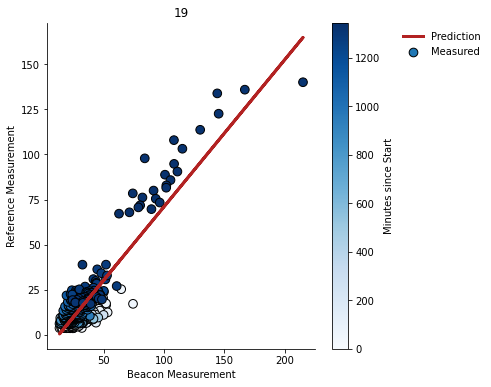

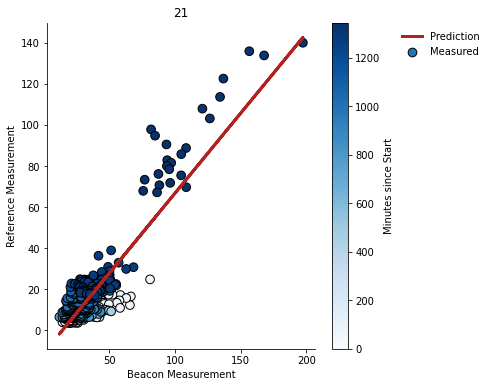

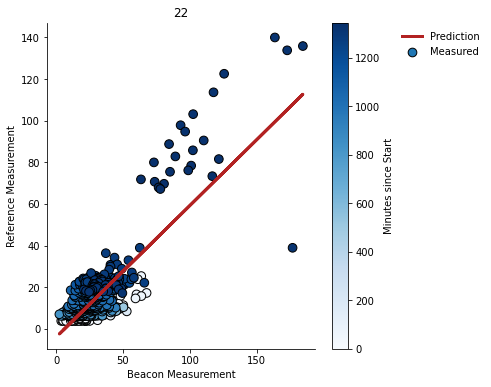

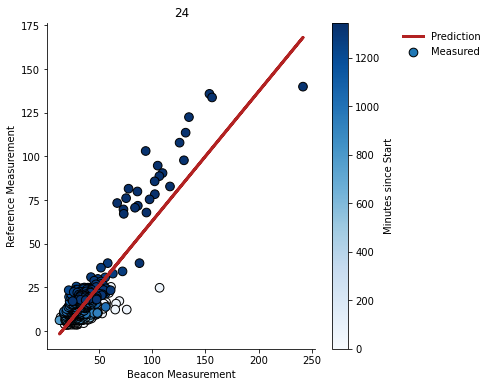

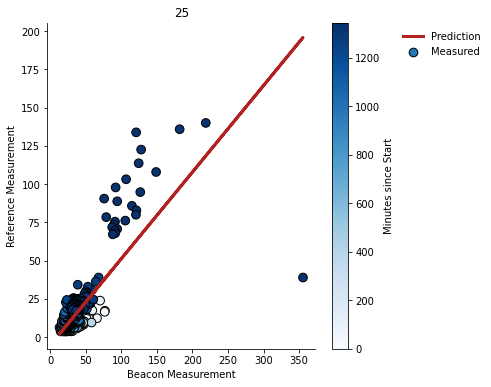

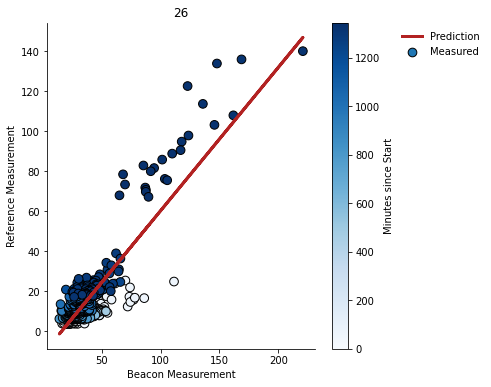

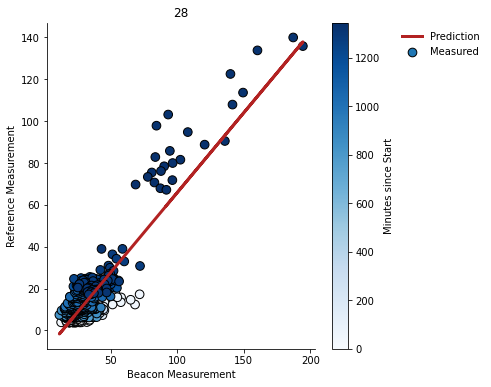

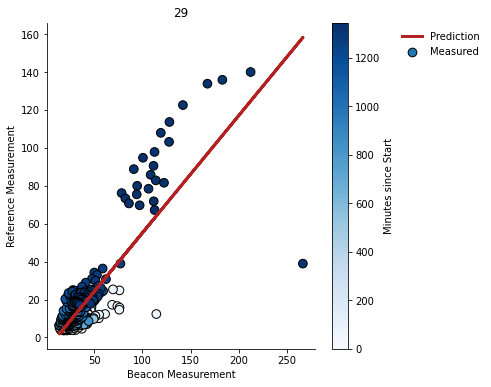

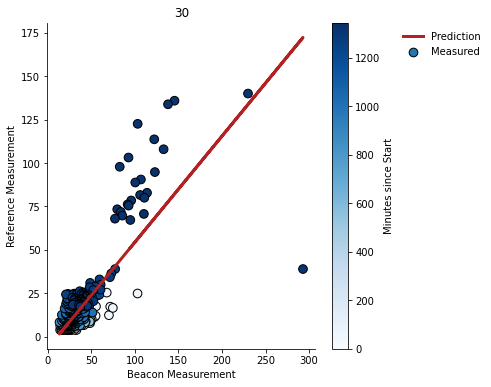

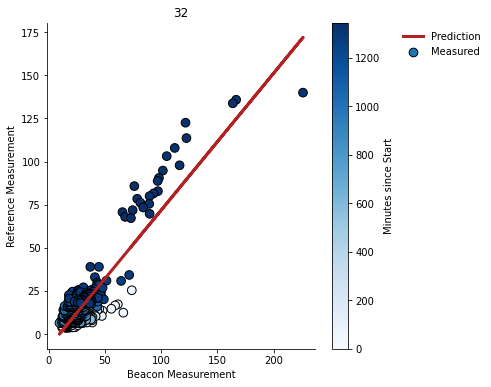

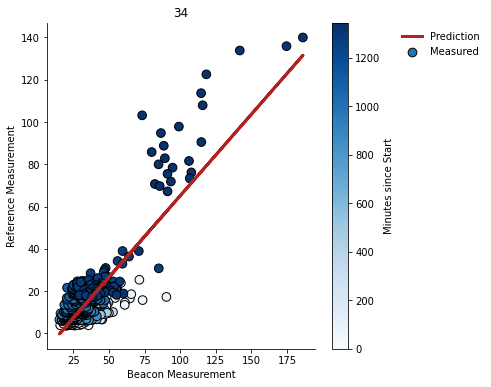

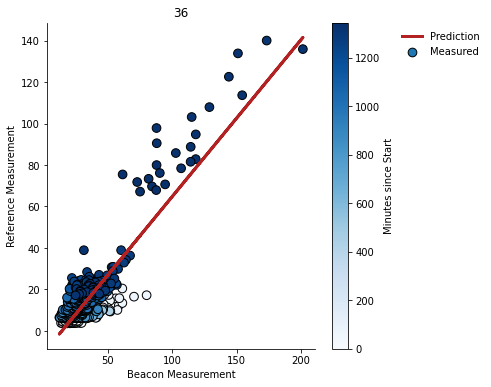

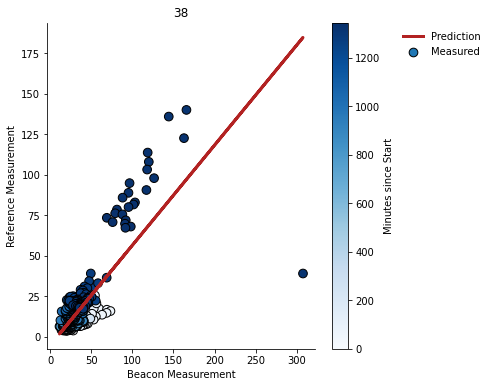

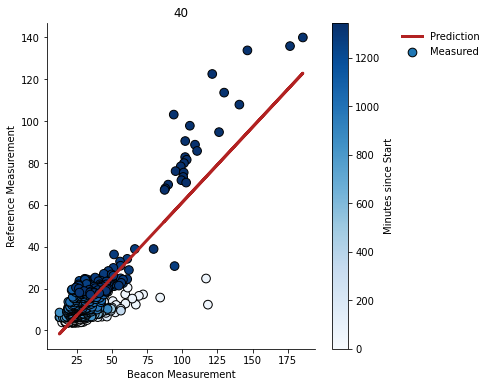

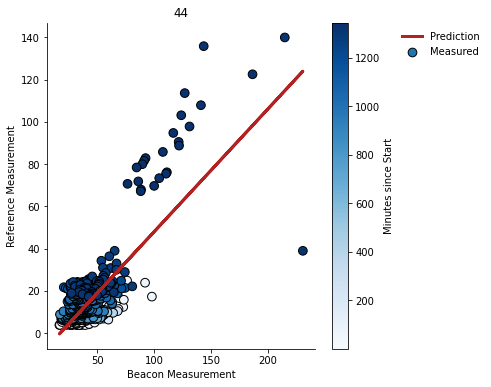

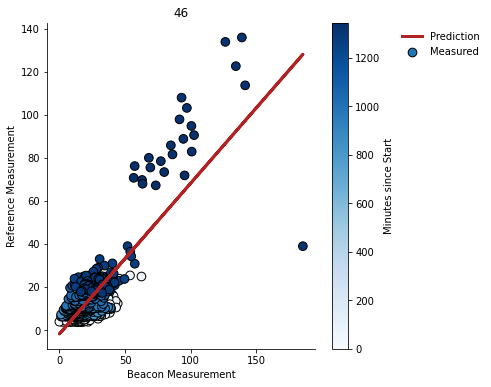

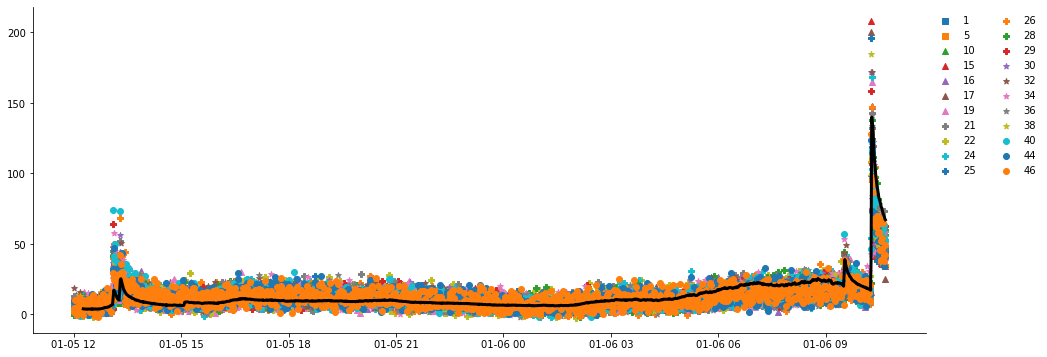

In [20]:
pm_number = ref["pm_number"]
pm_number["concentration"] = pm_number[f"pm{size}"]
ref["pm_number"] = pm_number
pm_number_lm = c.linear_regression(ref, beacon, f"pm_number", f"pm{size}_number",verbose=False,save_to_file=True,show_plot=True,show_corrected=True)

## Carbon Dioxide
CO2 is measured by the [Sensirion SCD30](https://www.sensirion.com/fileadmin/user_upload/customers/sensirion/Dokumente/9.5_CO2/Sensirion_CO2_Sensors_SCD30_Datasheet.pdf) sensor with the following specs:

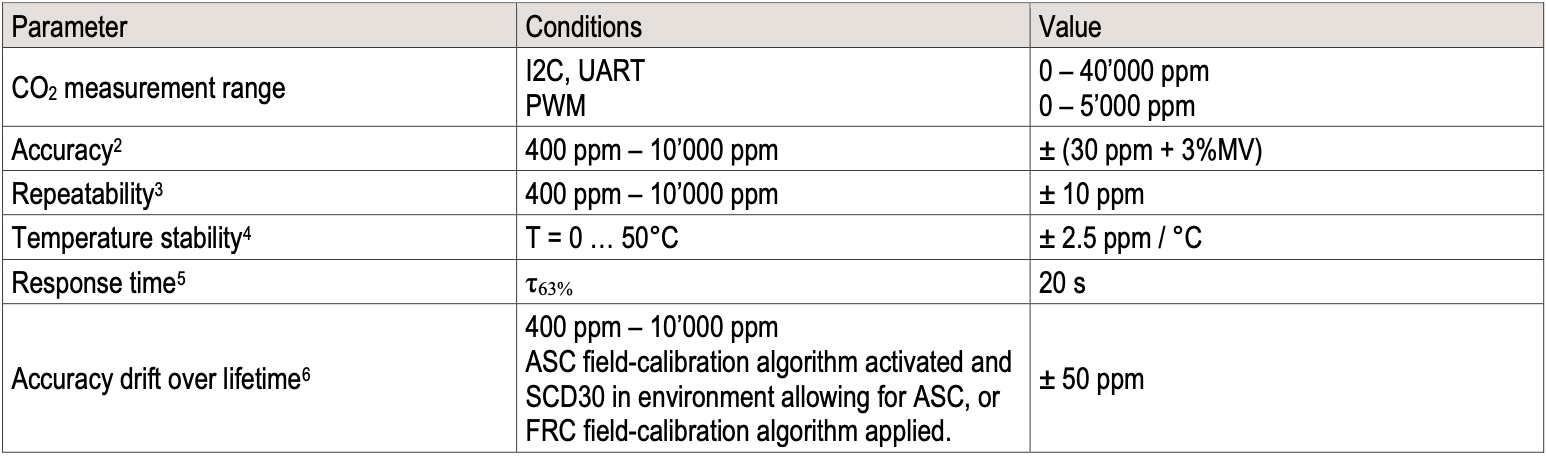

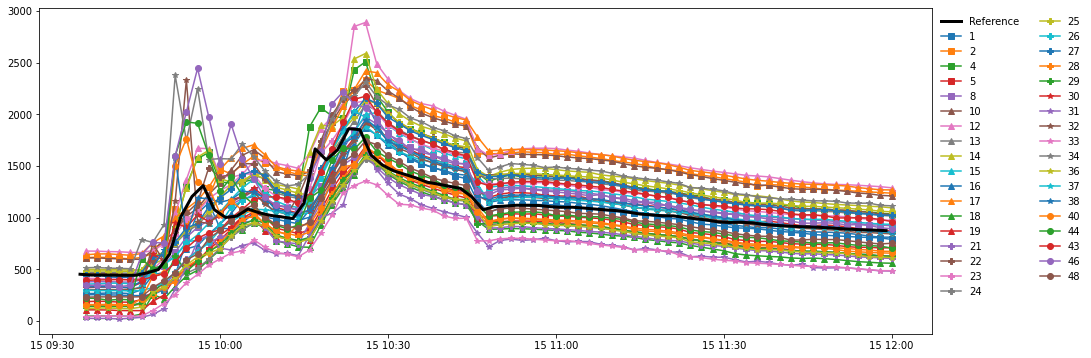

In [23]:
c.compare_time_series(ref["co2"],beacon[["co2","beacon"]])

### Non-Responsive Beacons

In [24]:
missing_co2, reporting_co2 = c.get_reporting_beacons(beacon,"co2")

Missing data from: [35]


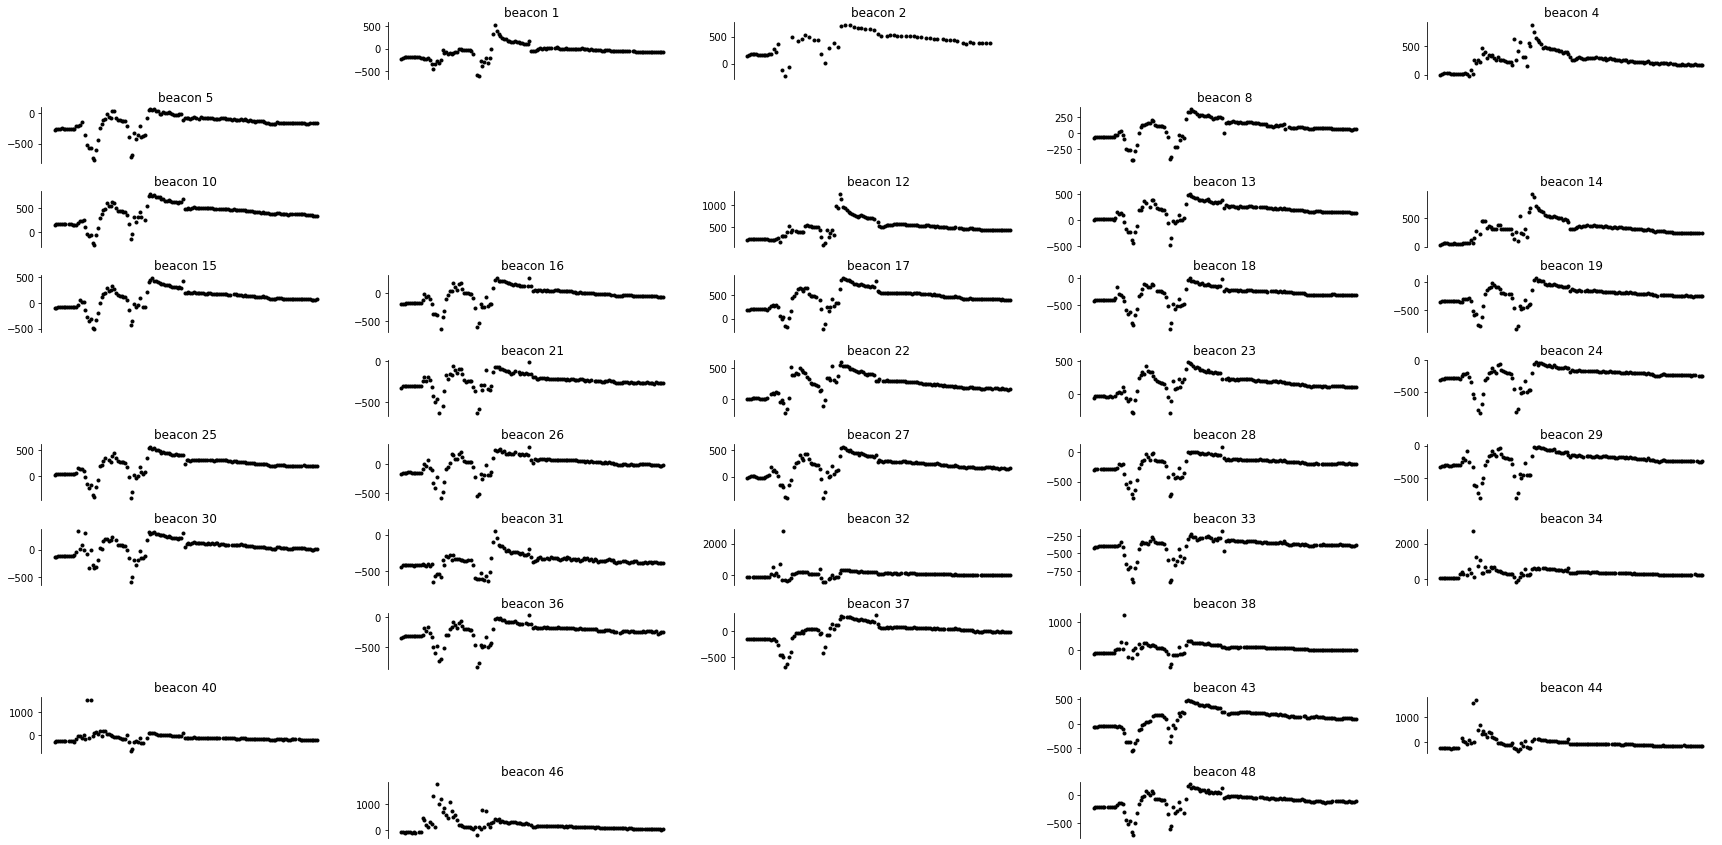

In [39]:
co2_offset = c.offset(ref, beacon, "co2", "co2", baseline=400, save_to_file=False, show_corrected=False)

### Linear Regression

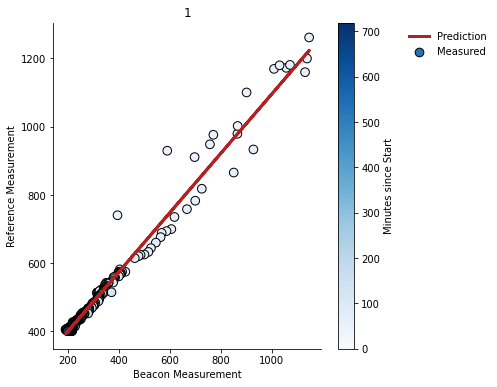

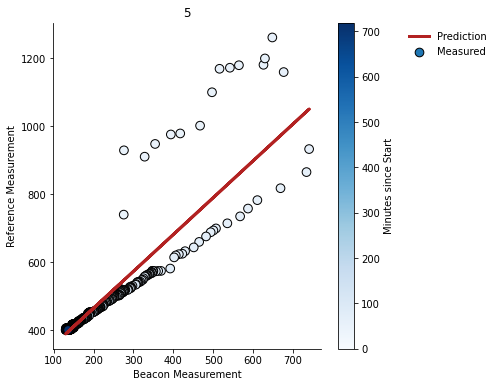

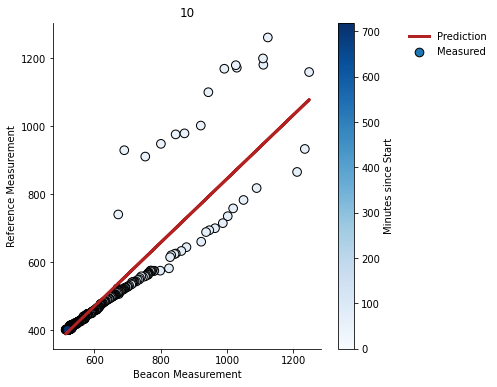

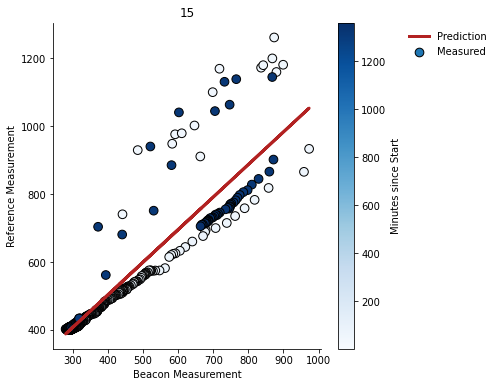

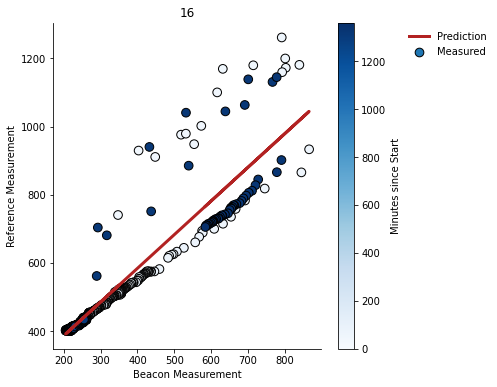

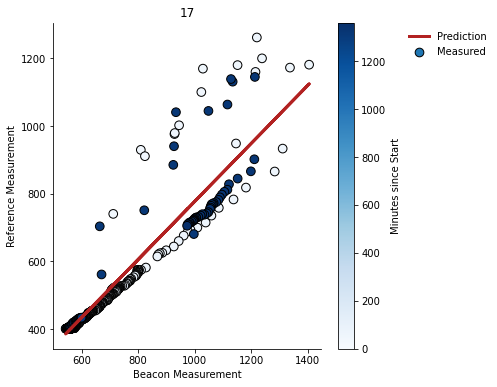

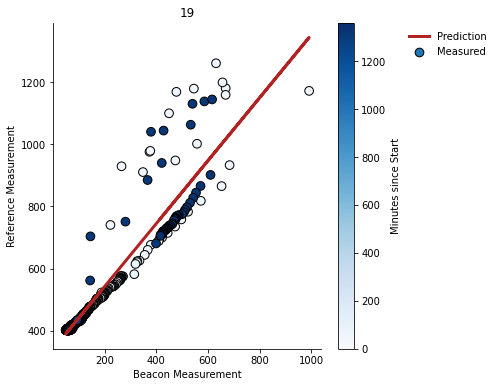

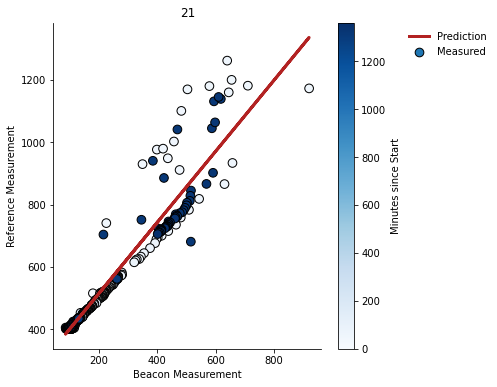

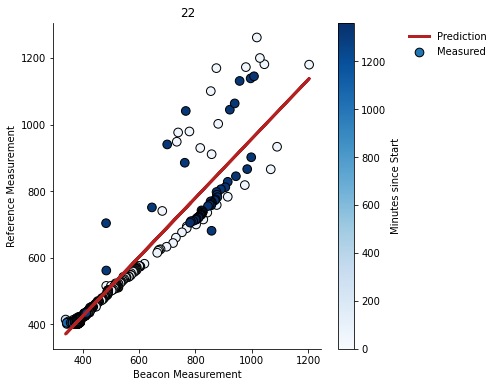

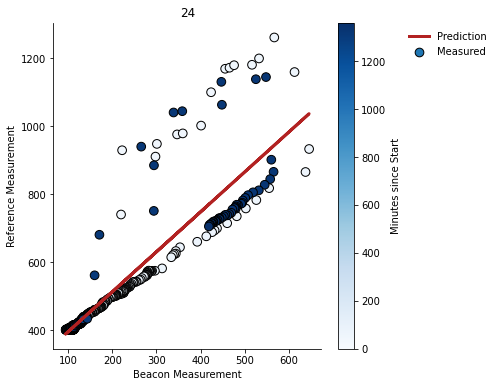

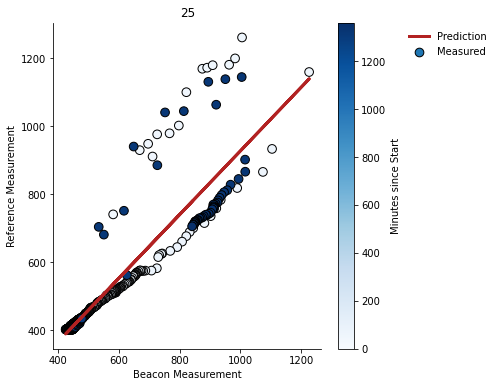

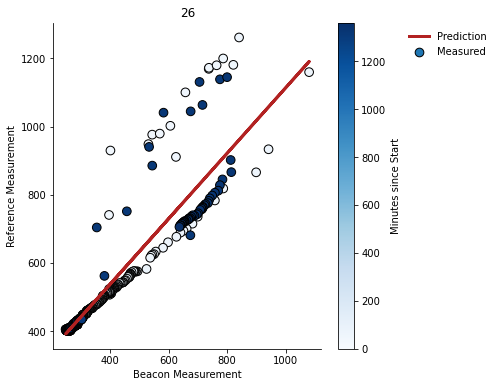

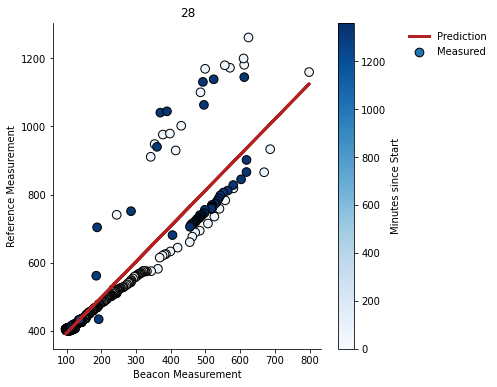

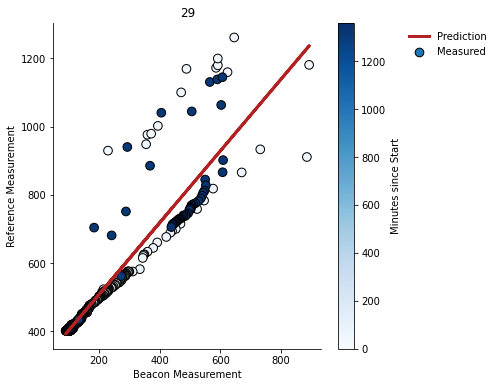

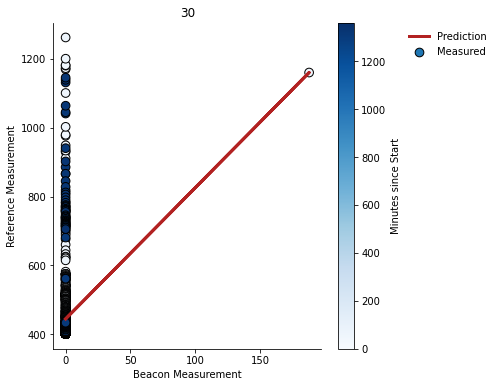

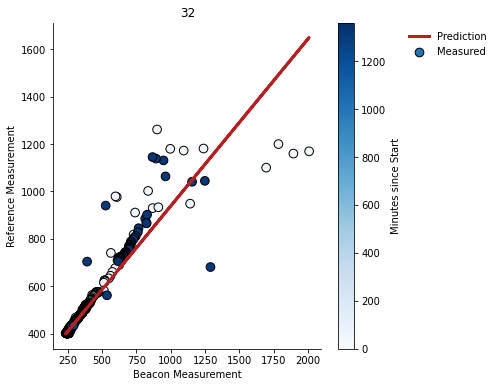

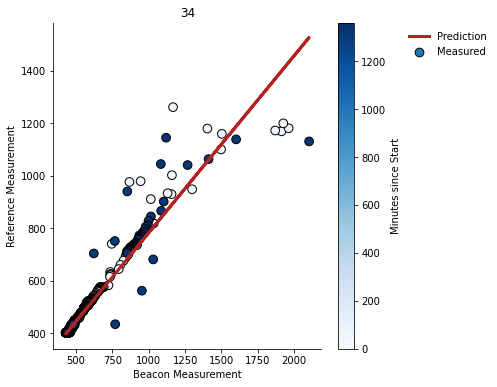

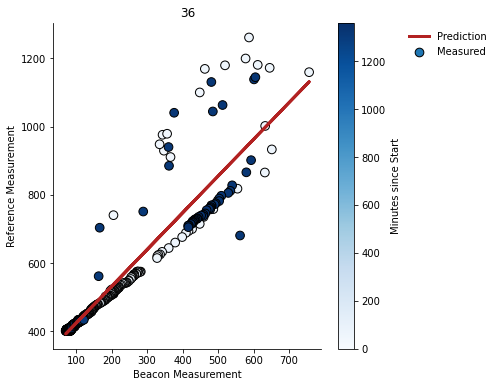

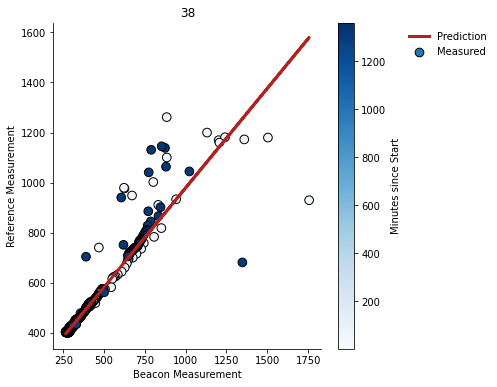

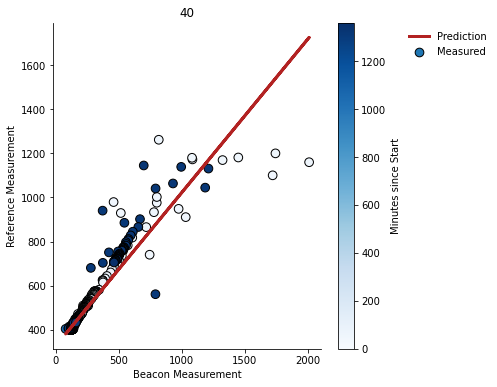

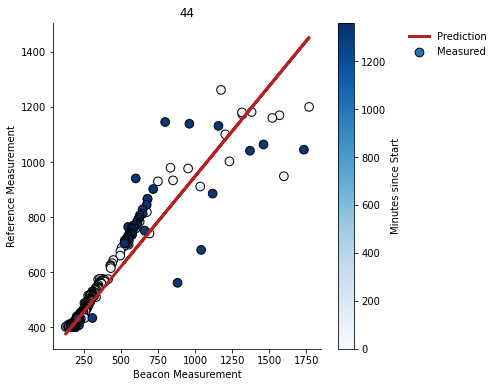

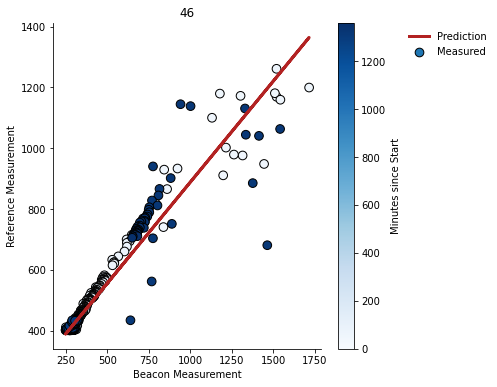

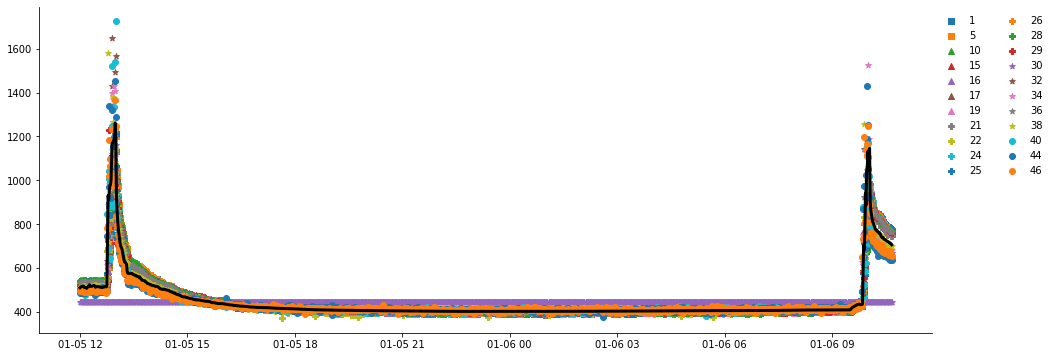

In [18]:
m = c.linear_regression(ref, beacon, "co2", "co2",verbose=False,save_to_file=True,show_plot=True,show_corrected=True)